### Environment Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torchsummary import summary
from mpl_toolkits.axes_grid1 import ImageGrid
from torch.utils.data import Dataset, DataLoader

In [2]:
# set up the device
if torch.cuda.is_available():
    device = torch.device("cuda")          
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('Using CPU')

Using GPU: NVIDIA GeForce RTX 3070 Laptop GPU


In [3]:
# avoid CUDA errors
CUDA_LAUNCH_BLOCKING=1

In [4]:
# empty cache
torch.cuda.empty_cache()

### Data Processing

#### Define the training dataset and processing functions

In [5]:
class Monet(Dataset):
    # initializaion method
    def __init__(self, dir_path, transform=None):
        self.dir_path = dir_path
        self.transform = transform
        # sort the names of all images and assign them
        self.filenames = sorted([f for f in os.listdir(dir_path) 
                                 if os.path.isfile(os.path.join(dir_path, f))])

    def __len__(self):
        # return the number of images in the dataset
        return len(self.filenames)
    
    # method to get item by index
    def __getitem__(self, idx):
        # create the path for the image
        img_path = os.path.join(self.dir_path, self.filenames[idx])
        try:
            # open the image if no error and convert it to RGB format
            img = Image.open(img_path).convert('RGB')
        # catch possible exceptions
        except (FileNotFoundError, PermissionError, PIL.UnidentifiedImageError) as e:
            print(f"Error opening image {img_path}: {e}")
            return None
        # check if the transform accessible
        if self.transform:
            # apply transform
            img = self.transform(img)

        return img

In [6]:
# customize image size
img_size= 64

# define transform
transform = transforms.Compose([
    # resize the image
    transforms.Resize(img_size),
    # convert to tensor type
    transforms.ToTensor(),
    # normalize to [-1, 1]
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
])

In [7]:
# create our traning dataset
dir_path = 'Monet'
dataset = Monet(dir_path, transform=transform)

In [8]:
# customize batch size
batch_size = 32

# define dataloader
dataloader = DataLoader(
    dataset,
    batch_size = batch_size,
    shuffle = True
)

In [9]:
# function to display (or save) an image, either for the image in dataset or the generated fake image
def show_image(image, epoch=None, iteration=None, loss=None, save=False):
    plt.figure(figsize = (4, 4))
    
    # convert tensor to a numpy array for plot
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).detach().numpy()

    # rescale image from [-1, 1] to [0,1]
    if np.min(image) < 0:
        image = (image + 1) / 2

    plt.imshow(image)
    
    # save option
    if save and epoch is not None and iteration is not None and loss is not None:
        filename = f'generated_img_epoch_{epoch}_iteration_{iteration}_loss_{loss:.3f}.png'
        plt.savefig(filename)
        
    plt.show()

In [10]:
# function to display a batch, either in the dataset or the generated fake batch
def show_batch(images_list, epoch=None, iteration=None, loss=None, save=False):
    fig = plt.figure(figsize = (14, 14))
    # define how many image space will be displayed
    lenth = int(np.ceil(np.sqrt(len(images_list))))
    shape = (lenth, lenth)
    
    grid = ImageGrid(fig, 111, nrows_ncols = shape, axes_pad = 0.05)

    # convert tensor to a numpy array for plot
    if isinstance(images_list, torch.Tensor):
        images_list = images_list.permute(0, 2, 3, 1).detach().numpy()

    # rescale image from [-1, 1] to [0,1]
    if np.min(images_list) < 0:
        images_list = (images_list + 1) / 2
    
    # plot grids
    for ax, image in zip(grid, images_list):
        ax.imshow(image)

    # save option
    if save and epoch is not None and iteration is not None and loss is not None:
        filename = f'generated_batch_epoch_{epoch}_iteration_{iteration}_loss_{loss:.3f}.png'
        plt.savefig(filename)

    plt.show()

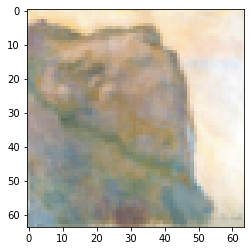

In [11]:
sample_image = next(iter(dataloader))[0]
show_image(sample_image)

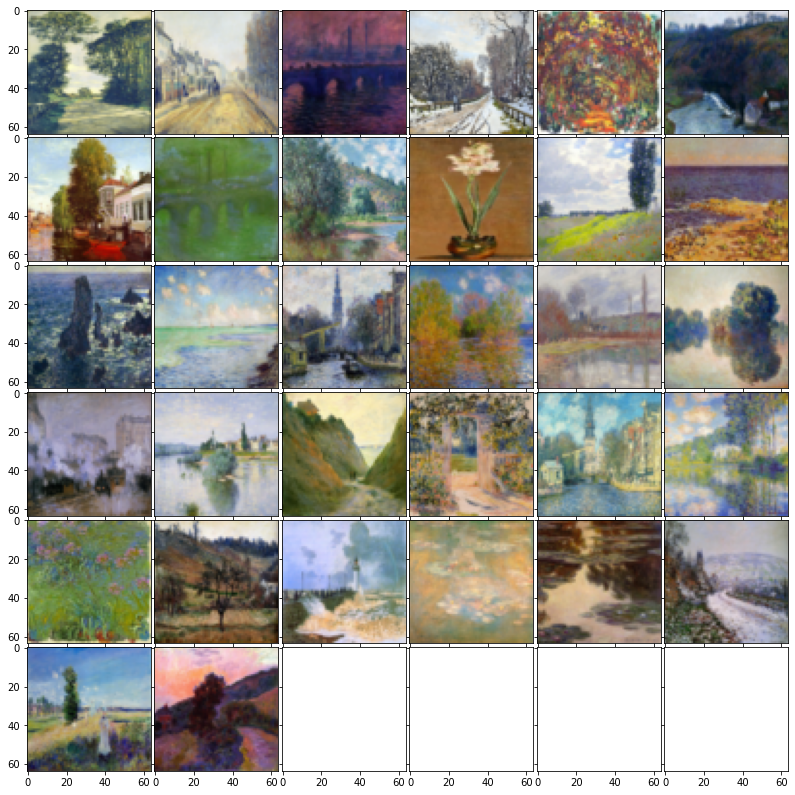

In [12]:
sample_batch = next(iter(dataloader))
show_batch(sample_batch)

### Model Construction

This class is for the discriminator component of our DCGAN, structured as a CNN. It classifies images between real(=1) or fake(=0). <br>
It includes five convolutional layers, each uses a 4x4 kernel with different strides and paddings, follwed by batch normalization, LeakyReLU, and the last layer ends with a flatten and a signoid function.

In [13]:
class Discriminator(nn.Module):
    # constructor method
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # input: 3 channels x (64x64)
            # output: 64 channels x (32x32)
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # output: 128 channels x (16x16)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # output: 256 channels x (8x8)
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # output: 512 channels x (4x4)
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # output: 1 channels x (1x1)
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # Output: N x 1 x 1 x 1
            
            # flatten to single dimension
            nn.Flatten(),
            # output probability
            nn.Sigmoid()
        )
    # forward mathod
    def forward(self, input):
        # take input to model
        return self.model(input)

In [14]:
# initialize the discriminator and move the params to gpu
discriminator = Discriminator().to(device)
# summary the disciminator
summary(discriminator, (3, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Flatten-13                    [-1, 1]               0
          Sigmoid-14                   

In [15]:
class Generator(nn.Module):
    # constructor method with noise dimension initialized
    def __init__(self, noise_dim=128):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            # input: noise_dim channels x (1x1)
            # output: 512 channels x (4x4)
            nn.ConvTranspose2d(noise_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            # output: 256 channels x (8x8)
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            # output: 128 channels x (16x16)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # output: 64 channels x (32x32)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # output: 3 channels x (64x64)
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            
            # resize to [-1,1]
            nn.Tanh()
        )
    
    # forward method that takes noise as input
    def forward(self, noise):
        # reshape
        noise = noise.view(-1, noise_dim, 1, 1)
        return self.model(noise)

In [16]:
# define the dimension of the noise
noise_dim = 128
# initialize the generator and move the params to gpu
generator = Generator(noise_dim=noise_dim).to(device)
# summary the generator
summary(generator, (noise_dim, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,048,576
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

### Training

In [17]:
# set Binary Cross Entropy as loss function
criterion = nn.BCELoss()
# learning rate
lr = 0.0002
# for GAN, Adam's beta1 is suggested as 0.5
beta1 = 0.5

# define optimizers for G and D
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

[0/200][0/43] Loss_D: 1.8926447629928589, Loss_G: 1.8421701192855835
[0/200][1/43] Loss_D: 1.089717149734497, Loss_G: 3.581625461578369
[0/200][2/43] Loss_D: 0.5826895236968994, Loss_G: 3.537677764892578
[0/200][3/43] Loss_D: 0.6038907170295715, Loss_G: 3.069793701171875
[0/200][4/43] Loss_D: 0.4123179316520691, Loss_G: 3.8075451850891113
[0/200][5/43] Loss_D: 0.5281769633293152, Loss_G: 3.476099967956543
[0/200][6/43] Loss_D: 0.4433552026748657, Loss_G: 4.49747371673584
[0/200][7/43] Loss_D: 0.679253876209259, Loss_G: 2.490044355392456
[0/200][8/43] Loss_D: 1.1330201625823975, Loss_G: 5.335196495056152
[0/200][9/43] Loss_D: 0.9571987986564636, Loss_G: 2.33048677444458
[0/200][10/43] Loss_D: 0.76902174949646, Loss_G: 3.0560286045074463
[0/200][11/43] Loss_D: 0.4788323640823364, Loss_G: 4.566324234008789
[0/200][12/43] Loss_D: 0.2566879689693451, Loss_G: 4.2404069900512695
[0/200][13/43] Loss_D: 0.2739328145980835, Loss_G: 3.7274608612060547
[0/200][14/43] Loss_D: 0.3550328016281128, Lo

[2/200][34/43] Loss_D: 1.3458706140518188, Loss_G: 0.9798412322998047
[2/200][35/43] Loss_D: 1.376720905303955, Loss_G: 1.3212823867797852
[2/200][36/43] Loss_D: 0.9866724014282227, Loss_G: 2.7041845321655273
[2/200][37/43] Loss_D: 0.6684430241584778, Loss_G: 2.7101924419403076
[2/200][38/43] Loss_D: 1.1325924396514893, Loss_G: 1.2205851078033447
[2/200][39/43] Loss_D: 1.033331274986267, Loss_G: 2.162971019744873
[2/200][40/43] Loss_D: 0.836909294128418, Loss_G: 2.441504955291748
[2/200][41/43] Loss_D: 1.0637075901031494, Loss_G: 2.0249831676483154
[2/200][42/43] Loss_D: 0.7441786527633667, Loss_G: 2.1148054599761963
[3/200][0/43] Loss_D: 1.1755387783050537, Loss_G: 1.6193504333496094
[3/200][1/43] Loss_D: 0.9168974161148071, Loss_G: 2.899881362915039
[3/200][2/43] Loss_D: 1.0137174129486084, Loss_G: 1.3901121616363525
[3/200][3/43] Loss_D: 1.218485713005066, Loss_G: 3.7983882427215576
[3/200][4/43] Loss_D: 0.9411355257034302, Loss_G: 2.222649335861206
[3/200][5/43] Loss_D: 0.841000556

[5/200][25/43] Loss_D: 0.5935443043708801, Loss_G: 2.6561079025268555
[5/200][26/43] Loss_D: 1.038691759109497, Loss_G: 6.084920883178711
[5/200][27/43] Loss_D: 1.1178089380264282, Loss_G: 2.7666561603546143
[5/200][28/43] Loss_D: 0.8569504022598267, Loss_G: 4.328677177429199
[5/200][29/43] Loss_D: 0.31138846278190613, Loss_G: 4.616809844970703
[5/200][30/43] Loss_D: 0.14747384190559387, Loss_G: 4.309915542602539
[5/200][31/43] Loss_D: 0.40249764919281006, Loss_G: 3.6063334941864014
[5/200][32/43] Loss_D: 0.49932053685188293, Loss_G: 3.8872733116149902
[5/200][33/43] Loss_D: 0.304339200258255, Loss_G: 4.605020523071289
[5/200][34/43] Loss_D: 0.5101324915885925, Loss_G: 3.9524447917938232
[5/200][35/43] Loss_D: 0.9121569991111755, Loss_G: 4.449106693267822
[5/200][36/43] Loss_D: 0.7368301153182983, Loss_G: 3.4947669506073
[5/200][37/43] Loss_D: 0.8435754776000977, Loss_G: 5.258077144622803
[5/200][38/43] Loss_D: 0.5156550407409668, Loss_G: 2.7324726581573486
[5/200][39/43] Loss_D: 0.725

[8/200][15/43] Loss_D: 1.022796869277954, Loss_G: 4.735134124755859
[8/200][16/43] Loss_D: 0.9456210732460022, Loss_G: 2.1973304748535156
[8/200][17/43] Loss_D: 1.187348484992981, Loss_G: 5.709993362426758
[8/200][18/43] Loss_D: 1.6101746559143066, Loss_G: 2.117893934249878
[8/200][19/43] Loss_D: 1.21543550491333, Loss_G: 4.931342601776123
[8/200][20/43] Loss_D: 0.4110414385795593, Loss_G: 4.2151994705200195
[8/200][21/43] Loss_D: 1.0296244621276855, Loss_G: 2.146322250366211
[8/200][22/43] Loss_D: 1.2389769554138184, Loss_G: 5.74461555480957
[8/200][23/43] Loss_D: 1.5451091527938843, Loss_G: 1.477805495262146
[8/200][24/43] Loss_D: 1.062860369682312, Loss_G: 3.801309108734131
[8/200][25/43] Loss_D: 1.064989686012268, Loss_G: 3.0551223754882812
[8/200][26/43] Loss_D: 1.4371731281280518, Loss_G: 1.302844762802124
[8/200][27/43] Loss_D: 1.159559965133667, Loss_G: 3.2195825576782227
[8/200][28/43] Loss_D: 0.7346822619438171, Loss_G: 3.156087875366211
[8/200][29/43] Loss_D: 0.4603935480117

[11/200][5/43] Loss_D: 0.3655485510826111, Loss_G: 4.16552734375
[11/200][6/43] Loss_D: 0.216819167137146, Loss_G: 3.379556179046631
[11/200][7/43] Loss_D: 0.7242655754089355, Loss_G: 7.48598575592041
[11/200][8/43] Loss_D: 1.0493742227554321, Loss_G: 3.930630922317505
[11/200][9/43] Loss_D: 0.17622949182987213, Loss_G: 2.9308266639709473
[11/200][10/43] Loss_D: 0.554624617099762, Loss_G: 6.189019680023193
[11/200][11/43] Loss_D: 0.7674580216407776, Loss_G: 2.5436062812805176
[11/200][12/43] Loss_D: 0.8833329677581787, Loss_G: 4.23571252822876
[11/200][13/43] Loss_D: 0.7204146385192871, Loss_G: 3.104740858078003
[11/200][14/43] Loss_D: 0.9670708775520325, Loss_G: 5.06929349899292
[11/200][15/43] Loss_D: 0.8131766319274902, Loss_G: 2.048557758331299
[11/200][16/43] Loss_D: 0.6294336915016174, Loss_G: 5.563542366027832
[11/200][17/43] Loss_D: 0.15006336569786072, Loss_G: 5.804815292358398
[11/200][18/43] Loss_D: 0.20439013838768005, Loss_G: 3.757002353668213
[11/200][19/43] Loss_D: 0.277

[13/200][36/43] Loss_D: 0.2054174542427063, Loss_G: 4.4817047119140625
[13/200][37/43] Loss_D: 0.3644803762435913, Loss_G: 2.903660774230957
[13/200][38/43] Loss_D: 0.4086202383041382, Loss_G: 4.385684967041016
[13/200][39/43] Loss_D: 0.7234612703323364, Loss_G: 2.564018726348877
[13/200][40/43] Loss_D: 0.624638557434082, Loss_G: 4.704490661621094
[13/200][41/43] Loss_D: 0.387158066034317, Loss_G: 3.768425464630127
[13/200][42/43] Loss_D: 0.420208215713501, Loss_G: 2.6651031970977783
[14/200][0/43] Loss_D: 0.9407072067260742, Loss_G: 5.463934898376465
[14/200][1/43] Loss_D: 0.535061240196228, Loss_G: 3.8832266330718994
[14/200][2/43] Loss_D: 0.6929607391357422, Loss_G: 1.2465770244598389
[14/200][3/43] Loss_D: 1.2772176265716553, Loss_G: 4.678513050079346
[14/200][4/43] Loss_D: 1.4941372871398926, Loss_G: 2.1659390926361084
[14/200][5/43] Loss_D: 0.3483513593673706, Loss_G: 2.51187801361084
[14/200][6/43] Loss_D: 0.39825189113616943, Loss_G: 3.9063892364501953
[14/200][7/43] Loss_D: 0.

[16/200][25/43] Loss_D: 0.3445940911769867, Loss_G: 4.191288948059082
[16/200][26/43] Loss_D: 0.4367244243621826, Loss_G: 3.1405458450317383
[16/200][27/43] Loss_D: 1.0101431608200073, Loss_G: 5.989370822906494
[16/200][28/43] Loss_D: 1.4228742122650146, Loss_G: 2.2923192977905273
[16/200][29/43] Loss_D: 0.7613891363143921, Loss_G: 3.9765498638153076
[16/200][30/43] Loss_D: 0.5898616313934326, Loss_G: 4.068545341491699
[16/200][31/43] Loss_D: 0.4673653841018677, Loss_G: 2.910203456878662
[16/200][32/43] Loss_D: 0.4719218313694, Loss_G: 5.146834373474121
[16/200][33/43] Loss_D: 0.42110884189605713, Loss_G: 3.3211259841918945
[16/200][34/43] Loss_D: 0.40721777081489563, Loss_G: 3.6808624267578125
[16/200][35/43] Loss_D: 0.5968153476715088, Loss_G: 2.67565655708313
[16/200][36/43] Loss_D: 0.9733856320381165, Loss_G: 5.607078552246094
[16/200][37/43] Loss_D: 1.3035434484481812, Loss_G: 2.859675884246826
[16/200][38/43] Loss_D: 0.6495680212974548, Loss_G: 3.0671305656433105
[16/200][39/43] 

[19/200][14/43] Loss_D: 0.2852298319339752, Loss_G: 4.88160514831543
[19/200][15/43] Loss_D: 0.5556721687316895, Loss_G: 2.555420398712158
[19/200][16/43] Loss_D: 0.6743042469024658, Loss_G: 6.274165153503418
[19/200][17/43] Loss_D: 0.9961075782775879, Loss_G: 2.7510132789611816
[19/200][18/43] Loss_D: 0.882105827331543, Loss_G: 4.399425983428955
[19/200][19/43] Loss_D: 0.7369384765625, Loss_G: 2.7371647357940674
[19/200][20/43] Loss_D: 0.9441665410995483, Loss_G: 5.535217761993408
[19/200][21/43] Loss_D: 1.262749433517456, Loss_G: 2.8509039878845215
[19/200][22/43] Loss_D: 0.43674787878990173, Loss_G: 3.4686665534973145
[19/200][23/43] Loss_D: 0.5009161233901978, Loss_G: 4.161511421203613
[19/200][24/43] Loss_D: 0.3532178997993469, Loss_G: 3.7414722442626953
[19/200][25/43] Loss_D: 0.35704201459884644, Loss_G: 3.367800712585449
[19/200][26/43] Loss_D: 0.49495407938957214, Loss_G: 4.670520782470703
[19/200][27/43] Loss_D: 0.5634288787841797, Loss_G: 3.307548999786377
[19/200][28/43] Lo

[22/200][3/43] Loss_D: 0.47937947511672974, Loss_G: 3.0930869579315186
[22/200][4/43] Loss_D: 0.7851765155792236, Loss_G: 3.416513681411743
[22/200][5/43] Loss_D: 0.5617449283599854, Loss_G: 3.385270118713379
[22/200][6/43] Loss_D: 0.6595696210861206, Loss_G: 2.7357728481292725
[22/200][7/43] Loss_D: 0.7802624106407166, Loss_G: 1.8316917419433594
[22/200][8/43] Loss_D: 1.0302871465682983, Loss_G: 5.907227039337158
[22/200][9/43] Loss_D: 0.8145098686218262, Loss_G: 3.8062572479248047
[22/200][10/43] Loss_D: 0.29790136218070984, Loss_G: 2.9303202629089355
[22/200][11/43] Loss_D: 0.5075162649154663, Loss_G: 4.191267013549805
[22/200][12/43] Loss_D: 0.6710436344146729, Loss_G: 2.327385663986206
[22/200][13/43] Loss_D: 0.8346092700958252, Loss_G: 3.984602928161621
[22/200][14/43] Loss_D: 0.47941961884498596, Loss_G: 3.425873279571533
[22/200][15/43] Loss_D: 0.37448355555534363, Loss_G: 3.148038864135742
[22/200][16/43] Loss_D: 0.6620458364486694, Loss_G: 4.18996000289917
[22/200][17/43] Los

[24/200][35/43] Loss_D: 0.4496903717517853, Loss_G: 3.3328256607055664
[24/200][36/43] Loss_D: 1.1037687063217163, Loss_G: 6.652242660522461
[24/200][37/43] Loss_D: 1.568892240524292, Loss_G: 1.7053788900375366
[24/200][38/43] Loss_D: 1.4394562244415283, Loss_G: 6.233551979064941
[24/200][39/43] Loss_D: 0.7256372570991516, Loss_G: 4.479399681091309
[24/200][40/43] Loss_D: 0.5390310883522034, Loss_G: 2.0021491050720215
[24/200][41/43] Loss_D: 1.0244070291519165, Loss_G: 4.883284091949463
[24/200][42/43] Loss_D: 0.35714393854141235, Loss_G: 4.394322395324707
[25/200][0/43] Loss_D: 0.38304150104522705, Loss_G: 3.1942927837371826
[25/200][1/43] Loss_D: 0.44125697016716003, Loss_G: 3.5363337993621826
[25/200][2/43] Loss_D: 0.7645191550254822, Loss_G: 5.784107208251953
[25/200][3/43] Loss_D: 0.8699888586997986, Loss_G: 3.1959500312805176
[25/200][4/43] Loss_D: 0.9928445816040039, Loss_G: 3.848031759262085
[25/200][5/43] Loss_D: 0.22145013511180878, Loss_G: 4.182011604309082
[25/200][6/43] Lo

[27/200][25/43] Loss_D: 0.5586950778961182, Loss_G: 3.967667579650879
[27/200][26/43] Loss_D: 0.5071842670440674, Loss_G: 2.962554454803467
[27/200][27/43] Loss_D: 0.5372555255889893, Loss_G: 3.1090102195739746
[27/200][28/43] Loss_D: 0.3758888244628906, Loss_G: 3.8197131156921387
[27/200][29/43] Loss_D: 0.34823673963546753, Loss_G: 3.8869032859802246
[27/200][30/43] Loss_D: 0.3726973831653595, Loss_G: 3.119083881378174
[27/200][31/43] Loss_D: 0.700529932975769, Loss_G: 3.732351779937744
[27/200][32/43] Loss_D: 0.4687870740890503, Loss_G: 3.009207248687744
[27/200][33/43] Loss_D: 0.5801337957382202, Loss_G: 4.20005989074707
[27/200][34/43] Loss_D: 0.7044973969459534, Loss_G: 2.2862141132354736
[27/200][35/43] Loss_D: 0.8333239555358887, Loss_G: 3.680927038192749
[27/200][36/43] Loss_D: 0.39685577154159546, Loss_G: 3.7677602767944336
[27/200][37/43] Loss_D: 0.5463012456893921, Loss_G: 2.321507453918457
[27/200][38/43] Loss_D: 0.7115471363067627, Loss_G: 4.929975986480713
[27/200][39/43]

[30/200][14/43] Loss_D: 0.7764037251472473, Loss_G: 3.9448912143707275
[30/200][15/43] Loss_D: 0.5987460613250732, Loss_G: 2.7418015003204346
[30/200][16/43] Loss_D: 0.9812987446784973, Loss_G: 3.8612987995147705
[30/200][17/43] Loss_D: 0.6189888715744019, Loss_G: 2.9190311431884766
[30/200][18/43] Loss_D: 0.7224647998809814, Loss_G: 4.438041687011719
[30/200][19/43] Loss_D: 0.7001598477363586, Loss_G: 2.377840757369995
[30/200][20/43] Loss_D: 0.8220123052597046, Loss_G: 5.307466506958008
[30/200][21/43] Loss_D: 0.753550112247467, Loss_G: 2.768317699432373
[30/200][22/43] Loss_D: 0.9832550287246704, Loss_G: 4.64575719833374
[30/200][23/43] Loss_D: 0.44570907950401306, Loss_G: 4.535198211669922
[30/200][24/43] Loss_D: 0.6287861466407776, Loss_G: 3.29333758354187
[30/200][25/43] Loss_D: 0.48264816403388977, Loss_G: 4.616059303283691
[30/200][26/43] Loss_D: 0.588225781917572, Loss_G: 3.161454677581787
[30/200][27/43] Loss_D: 0.4803941249847412, Loss_G: 3.6787312030792236
[30/200][28/43] L

[33/200][3/43] Loss_D: 0.38652414083480835, Loss_G: 3.4261813163757324
[33/200][4/43] Loss_D: 0.4407365918159485, Loss_G: 5.445883750915527
[33/200][5/43] Loss_D: 0.5281820297241211, Loss_G: 3.4615182876586914
[33/200][6/43] Loss_D: 0.4003007411956787, Loss_G: 2.939373254776001
[33/200][7/43] Loss_D: 0.5512380599975586, Loss_G: 5.236124038696289
[33/200][8/43] Loss_D: 1.0308268070220947, Loss_G: 2.214883327484131
[33/200][9/43] Loss_D: 1.0677638053894043, Loss_G: 7.107675552368164
[33/200][10/43] Loss_D: 0.9598967432975769, Loss_G: 2.65956974029541
[33/200][11/43] Loss_D: 0.5808605551719666, Loss_G: 4.852848529815674
[33/200][12/43] Loss_D: 0.6646809577941895, Loss_G: 3.2135586738586426
[33/200][13/43] Loss_D: 0.35005661845207214, Loss_G: 4.822890281677246
[33/200][14/43] Loss_D: 0.36992567777633667, Loss_G: 4.4109015464782715
[33/200][15/43] Loss_D: 0.36235368251800537, Loss_G: 3.225555419921875
[33/200][16/43] Loss_D: 0.6153578162193298, Loss_G: 4.816032409667969
[33/200][17/43] Loss

[35/200][35/43] Loss_D: 0.6152915954589844, Loss_G: 4.797299861907959
[35/200][36/43] Loss_D: 0.6659860610961914, Loss_G: 3.3287887573242188
[35/200][37/43] Loss_D: 0.7618804574012756, Loss_G: 4.138881683349609
[35/200][38/43] Loss_D: 0.7121136784553528, Loss_G: 4.290504455566406
[35/200][39/43] Loss_D: 0.5503218173980713, Loss_G: 3.2059950828552246
[35/200][40/43] Loss_D: 0.5240718126296997, Loss_G: 3.8207221031188965
[35/200][41/43] Loss_D: 0.4483381509780884, Loss_G: 3.5820870399475098
[35/200][42/43] Loss_D: 0.36416542530059814, Loss_G: 4.414323806762695
[36/200][0/43] Loss_D: 0.5156539678573608, Loss_G: 3.157248020172119
[36/200][1/43] Loss_D: 0.30540210008621216, Loss_G: 4.02623176574707
[36/200][2/43] Loss_D: 0.21736663579940796, Loss_G: 4.58302640914917
[36/200][3/43] Loss_D: 0.43330609798431396, Loss_G: 5.195815563201904
[36/200][4/43] Loss_D: 0.5571211576461792, Loss_G: 3.4156436920166016
[36/200][5/43] Loss_D: 0.49676164984703064, Loss_G: 4.505251884460449
[36/200][6/43] Los

[38/200][24/43] Loss_D: 0.3303631544113159, Loss_G: 3.999018430709839
[38/200][25/43] Loss_D: 0.44239717721939087, Loss_G: 6.523971080780029
[38/200][26/43] Loss_D: 0.21845093369483948, Loss_G: 5.383895397186279
[38/200][27/43] Loss_D: 0.2229592502117157, Loss_G: 3.849470853805542
[38/200][28/43] Loss_D: 0.4106282591819763, Loss_G: 3.4437389373779297
[38/200][29/43] Loss_D: 0.599860429763794, Loss_G: 6.7764739990234375
[38/200][30/43] Loss_D: 0.4431441128253937, Loss_G: 4.785170078277588
[38/200][31/43] Loss_D: 0.2847444713115692, Loss_G: 3.57736873626709
[38/200][32/43] Loss_D: 1.0018787384033203, Loss_G: 8.090839385986328
[38/200][33/43] Loss_D: 1.042856216430664, Loss_G: 4.926855087280273
[38/200][34/43] Loss_D: 0.3027094006538391, Loss_G: 2.9300498962402344
[38/200][35/43] Loss_D: 0.7123843431472778, Loss_G: 7.2726922035217285
[38/200][36/43] Loss_D: 0.49462997913360596, Loss_G: 5.207322597503662
[38/200][37/43] Loss_D: 0.2683207392692566, Loss_G: 2.962160110473633
[38/200][38/43] 

[41/200][12/43] Loss_D: 0.5436369180679321, Loss_G: 3.8460769653320312
[41/200][13/43] Loss_D: 0.6561446785926819, Loss_G: 6.3904619216918945
[41/200][14/43] Loss_D: 0.659252405166626, Loss_G: 3.478372573852539
[41/200][15/43] Loss_D: 0.5587471723556519, Loss_G: 4.215031623840332
[41/200][16/43] Loss_D: 0.4660601317882538, Loss_G: 3.4051032066345215
[41/200][17/43] Loss_D: 0.41156840324401855, Loss_G: 4.350002765655518
[41/200][18/43] Loss_D: 0.592532753944397, Loss_G: 2.9778828620910645
[41/200][19/43] Loss_D: 0.428261399269104, Loss_G: 5.105747699737549
[41/200][20/43] Loss_D: 0.5951454043388367, Loss_G: 2.9465646743774414
[41/200][21/43] Loss_D: 0.6983777284622192, Loss_G: 5.198657989501953
[41/200][22/43] Loss_D: 0.15307234227657318, Loss_G: 5.1930389404296875
[41/200][23/43] Loss_D: 0.36199086904525757, Loss_G: 3.0875532627105713
[41/200][24/43] Loss_D: 0.6567330956459045, Loss_G: 5.7709760665893555
[41/200][25/43] Loss_D: 0.8377103805541992, Loss_G: 2.457413911819458
[41/200][26/

[44/200][1/43] Loss_D: 0.2357654571533203, Loss_G: 4.084639549255371
[44/200][2/43] Loss_D: 0.303987592458725, Loss_G: 3.227531671524048
[44/200][3/43] Loss_D: 0.4606827199459076, Loss_G: 5.303656578063965
[44/200][4/43] Loss_D: 0.30721211433410645, Loss_G: 4.5233540534973145
[44/200][5/43] Loss_D: 0.4563787579536438, Loss_G: 2.28800630569458
[44/200][6/43] Loss_D: 0.36504513025283813, Loss_G: 4.433413028717041
[44/200][7/43] Loss_D: 0.355532169342041, Loss_G: 4.970287322998047
[44/200][8/43] Loss_D: 0.31831488013267517, Loss_G: 3.976848602294922
[44/200][9/43] Loss_D: 0.46264052391052246, Loss_G: 4.393545150756836
[44/200][10/43] Loss_D: 0.4092940092086792, Loss_G: 5.789603233337402
[44/200][11/43] Loss_D: 0.6071237325668335, Loss_G: 3.025940418243408
[44/200][12/43] Loss_D: 0.34687936305999756, Loss_G: 4.086579322814941
[44/200][13/43] Loss_D: 0.44043296575546265, Loss_G: 6.177319526672363
[44/200][14/43] Loss_D: 0.2857682704925537, Loss_G: 4.997982025146484
[44/200][15/43] Loss_D: 0

[46/200][32/43] Loss_D: 1.2822394371032715, Loss_G: 9.860583305358887
[46/200][33/43] Loss_D: 1.7208502292633057, Loss_G: 5.451772689819336
[46/200][34/43] Loss_D: 0.16625165939331055, Loss_G: 3.4128293991088867
[46/200][35/43] Loss_D: 0.5364111661911011, Loss_G: 6.994809150695801
[46/200][36/43] Loss_D: 0.320173978805542, Loss_G: 5.223042964935303
[46/200][37/43] Loss_D: 0.2848457098007202, Loss_G: 4.085526466369629
[46/200][38/43] Loss_D: 0.24150559306144714, Loss_G: 4.321794509887695
[46/200][39/43] Loss_D: 0.5254006385803223, Loss_G: 6.471579551696777
[46/200][40/43] Loss_D: 0.5107027888298035, Loss_G: 4.283042907714844
[46/200][41/43] Loss_D: 0.37027621269226074, Loss_G: 3.829099178314209
[46/200][42/43] Loss_D: 0.44364118576049805, Loss_G: 6.015097141265869
[47/200][0/43] Loss_D: 0.45856979489326477, Loss_G: 4.05859375
[47/200][1/43] Loss_D: 0.3648332357406616, Loss_G: 3.6221728324890137
[47/200][2/43] Loss_D: 0.4480750560760498, Loss_G: 4.52756404876709
[47/200][3/43] Loss_D: 0.

[49/200][21/43] Loss_D: 0.5727828741073608, Loss_G: 4.056105613708496
[49/200][22/43] Loss_D: 0.26178574562072754, Loss_G: 2.853408098220825
[49/200][23/43] Loss_D: 0.9055869579315186, Loss_G: 7.810611724853516
[49/200][24/43] Loss_D: 0.7060077786445618, Loss_G: 3.7541027069091797
[49/200][25/43] Loss_D: 0.27271518111228943, Loss_G: 4.007319450378418
[49/200][26/43] Loss_D: 0.5944727659225464, Loss_G: 7.226596355438232
[49/200][27/43] Loss_D: 1.4257423877716064, Loss_G: 2.5467352867126465
[49/200][28/43] Loss_D: 0.7702069878578186, Loss_G: 6.398609161376953
[49/200][29/43] Loss_D: 0.5868618488311768, Loss_G: 3.505643129348755
[49/200][30/43] Loss_D: 0.3989778757095337, Loss_G: 3.547671318054199
[49/200][31/43] Loss_D: 0.498441606760025, Loss_G: 5.049880027770996
[49/200][32/43] Loss_D: 0.44055047631263733, Loss_G: 3.742142677307129
[49/200][33/43] Loss_D: 0.5419500470161438, Loss_G: 4.7807207107543945
[49/200][34/43] Loss_D: 0.8459110856056213, Loss_G: 2.893949508666992
[49/200][35/43]

[52/200][9/43] Loss_D: 0.5324921011924744, Loss_G: 5.536571025848389
[52/200][10/43] Loss_D: 0.5391683578491211, Loss_G: 3.8569107055664062
[52/200][11/43] Loss_D: 0.41223543882369995, Loss_G: 5.413396835327148
[52/200][12/43] Loss_D: 0.28478947281837463, Loss_G: 4.630674362182617
[52/200][13/43] Loss_D: 0.43642592430114746, Loss_G: 3.8881778717041016
[52/200][14/43] Loss_D: 0.3991950750350952, Loss_G: 5.534873962402344
[52/200][15/43] Loss_D: 0.4803682565689087, Loss_G: 3.8105363845825195
[52/200][16/43] Loss_D: 0.545424222946167, Loss_G: 5.507505893707275
[52/200][17/43] Loss_D: 0.4746878743171692, Loss_G: 3.968804121017456
[52/200][18/43] Loss_D: 0.5012021660804749, Loss_G: 4.361356735229492
[52/200][19/43] Loss_D: 0.4673643410205841, Loss_G: 5.598222255706787
[52/200][20/43] Loss_D: 0.31585195660591125, Loss_G: 4.471260070800781
[52/200][21/43] Loss_D: 0.4989151954650879, Loss_G: 4.850340366363525
[52/200][22/43] Loss_D: 0.6091302633285522, Loss_G: 5.083621978759766
[52/200][23/43]

[54/200][41/43] Loss_D: 0.6796622276306152, Loss_G: 7.833285331726074
[54/200][42/43] Loss_D: 0.7603594064712524, Loss_G: 4.977323055267334
[55/200][0/43] Loss_D: 0.3229295015335083, Loss_G: 3.7867813110351562
[55/200][1/43] Loss_D: 0.43652892112731934, Loss_G: 4.996863842010498
[55/200][2/43] Loss_D: 0.4453614354133606, Loss_G: 5.548354148864746
[55/200][3/43] Loss_D: 0.5059399604797363, Loss_G: 3.841719388961792
[55/200][4/43] Loss_D: 0.3723832964897156, Loss_G: 5.771066665649414
[55/200][5/43] Loss_D: 0.3954281508922577, Loss_G: 4.153470039367676
[55/200][6/43] Loss_D: 0.38705921173095703, Loss_G: 4.274003028869629
[55/200][7/43] Loss_D: 0.4414030611515045, Loss_G: 6.42169713973999
[55/200][8/43] Loss_D: 0.7270262837409973, Loss_G: 2.7195792198181152
[55/200][9/43] Loss_D: 0.7319342494010925, Loss_G: 7.388788223266602
[55/200][10/43] Loss_D: 0.4797098636627197, Loss_G: 4.940494537353516
[55/200][11/43] Loss_D: 0.16620182991027832, Loss_G: 3.4142582416534424
[55/200][12/43] Loss_D: 0

[57/200][30/43] Loss_D: 0.4650379419326782, Loss_G: 3.6362180709838867
[57/200][31/43] Loss_D: 0.23624998331069946, Loss_G: 3.895874500274658
[57/200][32/43] Loss_D: 0.6109955906867981, Loss_G: 3.30057430267334
[57/200][33/43] Loss_D: 0.2941228151321411, Loss_G: 4.358587265014648
[57/200][34/43] Loss_D: 0.3741604685783386, Loss_G: 5.754340648651123
[57/200][35/43] Loss_D: 0.40977758169174194, Loss_G: 4.363457202911377
[57/200][36/43] Loss_D: 0.2619010806083679, Loss_G: 3.2645926475524902
[57/200][37/43] Loss_D: 0.35306715965270996, Loss_G: 4.512608051300049
[57/200][38/43] Loss_D: 0.5962410569190979, Loss_G: 5.245267868041992
[57/200][39/43] Loss_D: 0.4406164288520813, Loss_G: 3.584211587905884
[57/200][40/43] Loss_D: 0.5292796492576599, Loss_G: 3.0350098609924316
[57/200][41/43] Loss_D: 0.44866836071014404, Loss_G: 5.391024589538574
[57/200][42/43] Loss_D: 0.31154000759124756, Loss_G: 4.558278560638428
[58/200][0/43] Loss_D: 0.20006835460662842, Loss_G: 4.809075355529785
[58/200][1/43

[60/200][19/43] Loss_D: 0.3041697144508362, Loss_G: 5.203195571899414
[60/200][20/43] Loss_D: 0.3517601191997528, Loss_G: 4.097150802612305
[60/200][21/43] Loss_D: 0.30073559284210205, Loss_G: 3.9698681831359863
[60/200][22/43] Loss_D: 0.5031391382217407, Loss_G: 5.909034729003906
[60/200][23/43] Loss_D: 0.9254059195518494, Loss_G: 2.6564226150512695
[60/200][24/43] Loss_D: 0.802169144153595, Loss_G: 7.0389509201049805
[60/200][25/43] Loss_D: 0.6135701537132263, Loss_G: 3.2237555980682373
[60/200][26/43] Loss_D: 0.2611514925956726, Loss_G: 4.75132942199707
[60/200][27/43] Loss_D: 0.4033921957015991, Loss_G: 6.193256378173828
[60/200][28/43] Loss_D: 0.2874566614627838, Loss_G: 4.566878318786621
[60/200][29/43] Loss_D: 0.4447319507598877, Loss_G: 3.740546703338623
[60/200][30/43] Loss_D: 0.6189631819725037, Loss_G: 5.910151481628418
[60/200][31/43] Loss_D: 0.5389060974121094, Loss_G: 4.469152450561523
[60/200][32/43] Loss_D: 0.44482335448265076, Loss_G: 5.5072455406188965
[60/200][33/43]

[63/200][8/43] Loss_D: 0.381107896566391, Loss_G: 6.533567428588867
[63/200][9/43] Loss_D: 0.7687410712242126, Loss_G: 2.3144688606262207
[63/200][10/43] Loss_D: 0.4450283944606781, Loss_G: 5.616968154907227
[63/200][11/43] Loss_D: 0.3628859221935272, Loss_G: 5.553923606872559
[63/200][12/43] Loss_D: 0.31488338112831116, Loss_G: 3.6485133171081543
[63/200][13/43] Loss_D: 0.4842803180217743, Loss_G: 6.382439136505127
[63/200][14/43] Loss_D: 0.6589395403862, Loss_G: 3.3295674324035645
[63/200][15/43] Loss_D: 0.5466218590736389, Loss_G: 6.5355224609375
[63/200][16/43] Loss_D: 0.33308401703834534, Loss_G: 5.280289649963379
[63/200][17/43] Loss_D: 0.5655479431152344, Loss_G: 2.418135643005371
[63/200][18/43] Loss_D: 0.8293165564537048, Loss_G: 8.309568405151367
[63/200][19/43] Loss_D: 0.5311842560768127, Loss_G: 5.300235748291016
[63/200][20/43] Loss_D: 0.1627110093832016, Loss_G: 3.7534329891204834
[63/200][21/43] Loss_D: 0.34416404366493225, Loss_G: 6.124160289764404
[63/200][22/43] Loss_

[65/200][40/43] Loss_D: 0.3251202404499054, Loss_G: 4.506514072418213
[65/200][41/43] Loss_D: 0.20456403493881226, Loss_G: 5.2657880783081055
[65/200][42/43] Loss_D: 0.34957337379455566, Loss_G: 3.659127712249756
[66/200][0/43] Loss_D: 0.38564467430114746, Loss_G: 6.412342548370361
[66/200][1/43] Loss_D: 0.18123134970664978, Loss_G: 5.12549352645874
[66/200][2/43] Loss_D: 0.300700843334198, Loss_G: 4.514081954956055
[66/200][3/43] Loss_D: 0.29299014806747437, Loss_G: 5.160920143127441
[66/200][4/43] Loss_D: 0.20768316090106964, Loss_G: 4.808084487915039
[66/200][5/43] Loss_D: 0.26420220732688904, Loss_G: 3.4152371883392334
[66/200][6/43] Loss_D: 0.4497969448566437, Loss_G: 5.315161228179932
[66/200][7/43] Loss_D: 0.27603378891944885, Loss_G: 5.391299247741699
[66/200][8/43] Loss_D: 0.4294564723968506, Loss_G: 3.144752025604248
[66/200][9/43] Loss_D: 0.283616840839386, Loss_G: 4.879568099975586
[66/200][10/43] Loss_D: 0.2676372528076172, Loss_G: 4.335781097412109
[66/200][11/43] Loss_D:

[68/200][29/43] Loss_D: 0.4294534921646118, Loss_G: 3.0555195808410645
[68/200][30/43] Loss_D: 0.6666826605796814, Loss_G: 8.723209381103516
[68/200][31/43] Loss_D: 0.6159988045692444, Loss_G: 4.274303913116455
[68/200][32/43] Loss_D: 0.267433226108551, Loss_G: 3.6336779594421387
[68/200][33/43] Loss_D: 0.3269275426864624, Loss_G: 6.2780866622924805
[68/200][34/43] Loss_D: 0.3535171151161194, Loss_G: 4.281383514404297
[68/200][35/43] Loss_D: 0.27665063738822937, Loss_G: 5.249216556549072
[68/200][36/43] Loss_D: 0.1576104462146759, Loss_G: 4.84372615814209
[68/200][37/43] Loss_D: 0.4582608938217163, Loss_G: 2.0209157466888428
[68/200][38/43] Loss_D: 0.792768120765686, Loss_G: 8.508009910583496
[68/200][39/43] Loss_D: 0.38426512479782104, Loss_G: 4.907289505004883
[68/200][40/43] Loss_D: 0.37048396468162537, Loss_G: 3.2387290000915527
[68/200][41/43] Loss_D: 0.48747989535331726, Loss_G: 7.196078777313232
[68/200][42/43] Loss_D: 0.7039555907249451, Loss_G: 2.873605489730835
[69/200][0/43]

[71/200][17/43] Loss_D: 0.2748476564884186, Loss_G: 3.8911852836608887
[71/200][18/43] Loss_D: 0.3162636160850525, Loss_G: 5.629662990570068
[71/200][19/43] Loss_D: 0.3339077830314636, Loss_G: 3.9651503562927246
[71/200][20/43] Loss_D: 0.1765938699245453, Loss_G: 4.693220138549805
[71/200][21/43] Loss_D: 0.12896676361560822, Loss_G: 5.566402435302734
[71/200][22/43] Loss_D: 0.2269119918346405, Loss_G: 4.492099761962891
[71/200][23/43] Loss_D: 0.14858709275722504, Loss_G: 4.396434307098389
[71/200][24/43] Loss_D: 0.1628834307193756, Loss_G: 4.176259517669678
[71/200][25/43] Loss_D: 0.20099282264709473, Loss_G: 4.758818626403809
[71/200][26/43] Loss_D: 0.2399366945028305, Loss_G: 4.327136516571045
[71/200][27/43] Loss_D: 0.2089061588048935, Loss_G: 4.4878363609313965
[71/200][28/43] Loss_D: 0.1918475329875946, Loss_G: 4.319149494171143
[71/200][29/43] Loss_D: 0.3390055298805237, Loss_G: 5.5015082359313965
[71/200][30/43] Loss_D: 0.15444761514663696, Loss_G: 4.9350996017456055
[71/200][31

[74/200][5/43] Loss_D: 0.25782036781311035, Loss_G: 5.70993709564209
[74/200][6/43] Loss_D: 0.23758187890052795, Loss_G: 4.709218978881836
[74/200][7/43] Loss_D: 0.16307136416435242, Loss_G: 4.621769905090332
[74/200][8/43] Loss_D: 0.21255281567573547, Loss_G: 5.019956111907959
[74/200][9/43] Loss_D: 0.25384432077407837, Loss_G: 5.112651348114014
[74/200][10/43] Loss_D: 0.3026290535926819, Loss_G: 4.973402976989746
[74/200][11/43] Loss_D: 0.2576863169670105, Loss_G: 4.895591735839844
[74/200][12/43] Loss_D: 0.1649293601512909, Loss_G: 4.092392921447754
[74/200][13/43] Loss_D: 0.3693200349807739, Loss_G: 4.897433280944824
[74/200][14/43] Loss_D: 0.41124027967453003, Loss_G: 5.132228374481201
[74/200][15/43] Loss_D: 0.25983333587646484, Loss_G: 4.778696060180664
[74/200][16/43] Loss_D: 0.2217223048210144, Loss_G: 5.632449150085449
[74/200][17/43] Loss_D: 0.21841023862361908, Loss_G: 4.718997955322266
[74/200][18/43] Loss_D: 0.1735856831073761, Loss_G: 4.624392509460449
[74/200][19/43] Lo

[76/200][36/43] Loss_D: 0.5761535167694092, Loss_G: 4.265075206756592
[76/200][37/43] Loss_D: 0.1981310397386551, Loss_G: 5.339230060577393
[76/200][38/43] Loss_D: 0.26445305347442627, Loss_G: 5.975556373596191
[76/200][39/43] Loss_D: 0.21209874749183655, Loss_G: 5.062588691711426
[76/200][40/43] Loss_D: 0.26552891731262207, Loss_G: 4.610268592834473
[76/200][41/43] Loss_D: 0.36712878942489624, Loss_G: 5.580331802368164
[76/200][42/43] Loss_D: 0.16861814260482788, Loss_G: 5.974539756774902
[77/200][0/43] Loss_D: 0.26871034502983093, Loss_G: 5.029672622680664
[77/200][1/43] Loss_D: 0.176095649600029, Loss_G: 5.784144401550293
[77/200][2/43] Loss_D: 0.19942834973335266, Loss_G: 5.383304595947266
[77/200][3/43] Loss_D: 0.22414636611938477, Loss_G: 4.473478317260742
[77/200][4/43] Loss_D: 0.3041231632232666, Loss_G: 4.083010673522949
[77/200][5/43] Loss_D: 0.19076059758663177, Loss_G: 5.756015777587891
[77/200][6/43] Loss_D: 0.2086874544620514, Loss_G: 6.36136531829834
[77/200][7/43] Loss_

[79/200][25/43] Loss_D: 0.27972444891929626, Loss_G: 5.794896125793457
[79/200][26/43] Loss_D: 0.25277429819107056, Loss_G: 4.463772773742676
[79/200][27/43] Loss_D: 0.4038323760032654, Loss_G: 4.727356910705566
[79/200][28/43] Loss_D: 0.25138938426971436, Loss_G: 5.4773945808410645
[79/200][29/43] Loss_D: 0.36789488792419434, Loss_G: 3.9781110286712646
[79/200][30/43] Loss_D: 0.2816638946533203, Loss_G: 6.359257221221924
[79/200][31/43] Loss_D: 0.2817520499229431, Loss_G: 4.560544013977051
[79/200][32/43] Loss_D: 0.18310612440109253, Loss_G: 5.438533782958984
[79/200][33/43] Loss_D: 0.2842380702495575, Loss_G: 3.898113250732422
[79/200][34/43] Loss_D: 0.40904825925827026, Loss_G: 5.776264190673828
[79/200][35/43] Loss_D: 0.4444924592971802, Loss_G: 4.623997688293457
[79/200][36/43] Loss_D: 0.28275442123413086, Loss_G: 5.810149192810059
[79/200][37/43] Loss_D: 0.12426118552684784, Loss_G: 5.159897804260254
[79/200][38/43] Loss_D: 0.21234971284866333, Loss_G: 4.25787353515625
[79/200][3

[82/200][14/43] Loss_D: 0.11198622733354568, Loss_G: 5.036293029785156
[82/200][15/43] Loss_D: 0.2121439427137375, Loss_G: 4.087360858917236
[82/200][16/43] Loss_D: 0.2843627631664276, Loss_G: 6.80422306060791
[82/200][17/43] Loss_D: 0.20142492651939392, Loss_G: 5.5070953369140625
[82/200][18/43] Loss_D: 0.2522397041320801, Loss_G: 3.797823667526245
[82/200][19/43] Loss_D: 0.12696503102779388, Loss_G: 3.8144400119781494
[82/200][20/43] Loss_D: 0.18513216078281403, Loss_G: 5.645212173461914
[82/200][21/43] Loss_D: 0.21739399433135986, Loss_G: 6.2849884033203125
[82/200][22/43] Loss_D: 0.1875084787607193, Loss_G: 6.014956474304199
[82/200][23/43] Loss_D: 0.08149668574333191, Loss_G: 4.41473913192749
[82/200][24/43] Loss_D: 0.2765786647796631, Loss_G: 5.533015251159668
[82/200][25/43] Loss_D: 0.15735071897506714, Loss_G: 6.478159427642822
[82/200][26/43] Loss_D: 0.27130457758903503, Loss_G: 3.950924873352051
[82/200][27/43] Loss_D: 0.06841182708740234, Loss_G: 4.308394432067871
[82/200][2

[85/200][2/43] Loss_D: 0.589525043964386, Loss_G: 4.407427787780762
[85/200][3/43] Loss_D: 0.2252904772758484, Loss_G: 4.5228681564331055
[85/200][4/43] Loss_D: 0.3316918611526489, Loss_G: 6.913431644439697
[85/200][5/43] Loss_D: 0.2828914523124695, Loss_G: 5.648710250854492
[85/200][6/43] Loss_D: 0.39213699102401733, Loss_G: 4.310040473937988
[85/200][7/43] Loss_D: 0.28644490242004395, Loss_G: 5.049806594848633
[85/200][8/43] Loss_D: 0.2436540126800537, Loss_G: 5.313953399658203
[85/200][9/43] Loss_D: 0.4907289743423462, Loss_G: 6.11739444732666
[85/200][10/43] Loss_D: 0.2513332962989807, Loss_G: 5.987430572509766
[85/200][11/43] Loss_D: 0.2593805193901062, Loss_G: 4.9390716552734375
[85/200][12/43] Loss_D: 0.1980113387107849, Loss_G: 4.656484603881836
[85/200][13/43] Loss_D: 0.5155308246612549, Loss_G: 6.923435211181641
[85/200][14/43] Loss_D: 0.44893258810043335, Loss_G: 3.5106234550476074
[85/200][15/43] Loss_D: 0.4360392093658447, Loss_G: 6.12587308883667
[85/200][16/43] Loss_D: 0

[87/200][34/43] Loss_D: 0.11623893678188324, Loss_G: 4.421967506408691
[87/200][35/43] Loss_D: 0.23706570267677307, Loss_G: 6.150522232055664
[87/200][36/43] Loss_D: 0.14882878959178925, Loss_G: 5.241069793701172
[87/200][37/43] Loss_D: 0.15942426025867462, Loss_G: 4.107686996459961
[87/200][38/43] Loss_D: 0.26033255457878113, Loss_G: 7.494662284851074
[87/200][39/43] Loss_D: 0.22345328330993652, Loss_G: 5.3272809982299805
[87/200][40/43] Loss_D: 0.22809886932373047, Loss_G: 2.5129599571228027
[87/200][41/43] Loss_D: 0.4244133234024048, Loss_G: 9.499370574951172
[87/200][42/43] Loss_D: 0.2888086140155792, Loss_G: 5.462344169616699
[88/200][0/43] Loss_D: 0.05528159439563751, Loss_G: 5.250415325164795
[88/200][1/43] Loss_D: 0.21882544457912445, Loss_G: 7.289829254150391
[88/200][2/43] Loss_D: 0.08826714009046555, Loss_G: 6.4112348556518555
[88/200][3/43] Loss_D: 0.13424789905548096, Loss_G: 5.659290313720703
[88/200][4/43] Loss_D: 0.15027402341365814, Loss_G: 5.030978202819824
[88/200][5

[90/200][23/43] Loss_D: 0.4360271990299225, Loss_G: 9.212455749511719
[90/200][24/43] Loss_D: 0.11650198698043823, Loss_G: 7.038461685180664
[90/200][25/43] Loss_D: 0.105863556265831, Loss_G: 6.119937419891357
[90/200][26/43] Loss_D: 0.09590993076562881, Loss_G: 4.533695220947266
[90/200][27/43] Loss_D: 0.13698548078536987, Loss_G: 5.024896621704102
[90/200][28/43] Loss_D: 0.13179993629455566, Loss_G: 5.868438243865967
[90/200][29/43] Loss_D: 0.1219075471162796, Loss_G: 5.4020280838012695
[90/200][30/43] Loss_D: 0.288367360830307, Loss_G: 2.9213638305664062
[90/200][31/43] Loss_D: 0.40575283765792847, Loss_G: 8.965555191040039
[90/200][32/43] Loss_D: 0.3724108338356018, Loss_G: 4.556619644165039
[90/200][33/43] Loss_D: 0.10331195592880249, Loss_G: 5.376025199890137
[90/200][34/43] Loss_D: 0.1455567628145218, Loss_G: 7.0109148025512695
[90/200][35/43] Loss_D: 0.08984197676181793, Loss_G: 5.71358585357666
[90/200][36/43] Loss_D: 0.11958260089159012, Loss_G: 4.678557395935059
[90/200][37/

[93/200][12/43] Loss_D: 0.2279323935508728, Loss_G: 5.910832405090332
[93/200][13/43] Loss_D: 0.32088375091552734, Loss_G: 4.385660171508789
[93/200][14/43] Loss_D: 0.28790420293807983, Loss_G: 6.696362495422363
[93/200][15/43] Loss_D: 0.08040730655193329, Loss_G: 5.584718704223633
[93/200][16/43] Loss_D: 0.4645652770996094, Loss_G: 4.699742317199707
[93/200][17/43] Loss_D: 0.09265328198671341, Loss_G: 5.06591796875
[93/200][18/43] Loss_D: 0.19988436996936798, Loss_G: 7.385086536407471
[93/200][19/43] Loss_D: 0.2664436399936676, Loss_G: 4.394036769866943
[93/200][20/43] Loss_D: 0.2977808713912964, Loss_G: 4.059650421142578
[93/200][21/43] Loss_D: 0.28976160287857056, Loss_G: 7.752898216247559
[93/200][22/43] Loss_D: 0.1513364464044571, Loss_G: 5.978113174438477
[93/200][23/43] Loss_D: 0.2084624022245407, Loss_G: 4.687854290008545
[93/200][24/43] Loss_D: 0.14886674284934998, Loss_G: 5.232752799987793
[93/200][25/43] Loss_D: 0.16329710185527802, Loss_G: 6.591744422912598
[93/200][26/43] 

[96/200][1/43] Loss_D: 0.15584301948547363, Loss_G: 6.400306701660156
[96/200][2/43] Loss_D: 0.08062988519668579, Loss_G: 6.241765975952148
[96/200][3/43] Loss_D: 0.305442214012146, Loss_G: 5.651847839355469
[96/200][4/43] Loss_D: 0.21676546335220337, Loss_G: 5.404231548309326
[96/200][5/43] Loss_D: 0.1794513463973999, Loss_G: 6.746320724487305
[96/200][6/43] Loss_D: 0.500683069229126, Loss_G: 3.3910250663757324
[96/200][7/43] Loss_D: 0.49097567796707153, Loss_G: 8.766243934631348
[96/200][8/43] Loss_D: 0.12126471847295761, Loss_G: 7.424366474151611
[96/200][9/43] Loss_D: 0.22653374075889587, Loss_G: 4.402389049530029
[96/200][10/43] Loss_D: 0.33762839436531067, Loss_G: 7.391846179962158
[96/200][11/43] Loss_D: 0.11909118294715881, Loss_G: 6.521339416503906
[96/200][12/43] Loss_D: 0.10434897989034653, Loss_G: 5.400421142578125
[96/200][13/43] Loss_D: 0.18420687317848206, Loss_G: 5.016209125518799
[96/200][14/43] Loss_D: 0.2178831547498703, Loss_G: 6.66994571685791
[96/200][15/43] Loss_

[98/200][33/43] Loss_D: 0.09613217413425446, Loss_G: 4.928893566131592
[98/200][34/43] Loss_D: 0.09362976253032684, Loss_G: 5.677639484405518
[98/200][35/43] Loss_D: 0.14760807156562805, Loss_G: 6.723540782928467
[98/200][36/43] Loss_D: 0.20187972486019135, Loss_G: 4.217558860778809
[98/200][37/43] Loss_D: 0.1141943633556366, Loss_G: 5.4247236251831055
[98/200][38/43] Loss_D: 0.0695364847779274, Loss_G: 5.636819839477539
[98/200][39/43] Loss_D: 0.09880241751670837, Loss_G: 5.298244476318359
[98/200][40/43] Loss_D: 0.11050759255886078, Loss_G: 4.945428848266602
[98/200][41/43] Loss_D: 0.051906414330005646, Loss_G: 4.991725444793701
[98/200][42/43] Loss_D: 0.09503673017024994, Loss_G: 4.727046012878418
[99/200][0/43] Loss_D: 0.07840551435947418, Loss_G: 5.1833295822143555
[99/200][1/43] Loss_D: 0.06827463209629059, Loss_G: 5.3499884605407715
[99/200][2/43] Loss_D: 0.12918007373809814, Loss_G: 5.103700637817383
[99/200][3/43] Loss_D: 0.12606608867645264, Loss_G: 6.645954132080078
[99/200]

[101/200][20/43] Loss_D: 0.11110470443964005, Loss_G: 3.8755412101745605
[101/200][21/43] Loss_D: 0.14921462535858154, Loss_G: 6.132979393005371
[101/200][22/43] Loss_D: 0.11914067715406418, Loss_G: 5.962122917175293
[101/200][23/43] Loss_D: 0.05499536544084549, Loss_G: 5.890355587005615
[101/200][24/43] Loss_D: 0.08295649290084839, Loss_G: 4.979752063751221
[101/200][25/43] Loss_D: 0.1366731971502304, Loss_G: 5.624493598937988
[101/200][26/43] Loss_D: 0.09902092814445496, Loss_G: 5.6220622062683105
[101/200][27/43] Loss_D: 0.0638686865568161, Loss_G: 5.574870586395264
[101/200][28/43] Loss_D: 0.06493327021598816, Loss_G: 5.5315141677856445
[101/200][29/43] Loss_D: 0.07909458875656128, Loss_G: 4.970176696777344
[101/200][30/43] Loss_D: 0.14294399321079254, Loss_G: 5.056076526641846
[101/200][31/43] Loss_D: 0.08760260790586472, Loss_G: 5.466724872589111
[101/200][32/43] Loss_D: 0.08251044154167175, Loss_G: 4.886194229125977
[101/200][33/43] Loss_D: 0.12177890539169312, Loss_G: 6.1017580

[104/200][6/43] Loss_D: 0.5202369093894958, Loss_G: 4.392096996307373
[104/200][7/43] Loss_D: 0.313296914100647, Loss_G: 7.01702356338501
[104/200][8/43] Loss_D: 0.11336784064769745, Loss_G: 6.466578960418701
[104/200][9/43] Loss_D: 0.17581342160701752, Loss_G: 5.447075843811035
[104/200][10/43] Loss_D: 0.32831788063049316, Loss_G: 7.597962379455566
[104/200][11/43] Loss_D: 0.3497948944568634, Loss_G: 5.2445526123046875
[104/200][12/43] Loss_D: 0.23706091940402985, Loss_G: 5.644405364990234
[104/200][13/43] Loss_D: 0.26673924922943115, Loss_G: 6.501007080078125
[104/200][14/43] Loss_D: 0.2746647596359253, Loss_G: 4.948657989501953
[104/200][15/43] Loss_D: 0.4566909670829773, Loss_G: 7.282556533813477
[104/200][16/43] Loss_D: 0.14183741807937622, Loss_G: 6.354284763336182
[104/200][17/43] Loss_D: 0.13933078944683075, Loss_G: 6.180152893066406
[104/200][18/43] Loss_D: 0.24368028342723846, Loss_G: 4.656055450439453
[104/200][19/43] Loss_D: 0.2266796976327896, Loss_G: 6.040533065795898
[10

[106/200][36/43] Loss_D: 0.2262672781944275, Loss_G: 3.984060287475586
[106/200][37/43] Loss_D: 0.1280730962753296, Loss_G: 5.457258224487305
[106/200][38/43] Loss_D: 0.07647481560707092, Loss_G: 5.148780822753906
[106/200][39/43] Loss_D: 0.1443219780921936, Loss_G: 4.296426773071289
[106/200][40/43] Loss_D: 0.11859992146492004, Loss_G: 5.473075866699219
[106/200][41/43] Loss_D: 0.09440635144710541, Loss_G: 5.43413782119751
[106/200][42/43] Loss_D: 0.1586313545703888, Loss_G: 4.449714183807373
[107/200][0/43] Loss_D: 0.06934043765068054, Loss_G: 4.293764114379883
[107/200][1/43] Loss_D: 0.181088387966156, Loss_G: 7.126648426055908
[107/200][2/43] Loss_D: 0.05124174430966377, Loss_G: 6.7137250900268555
[107/200][3/43] Loss_D: 0.1716899573802948, Loss_G: 5.462960243225098
[107/200][4/43] Loss_D: 0.11018365621566772, Loss_G: 4.896401405334473
[107/200][5/43] Loss_D: 0.22676028311252594, Loss_G: 7.572943687438965
[107/200][6/43] Loss_D: 0.21284298598766327, Loss_G: 6.0131120681762695
[107/

[109/200][23/43] Loss_D: 0.10385963320732117, Loss_G: 4.9880876541137695
[109/200][24/43] Loss_D: 0.08666330575942993, Loss_G: 4.599795341491699
[109/200][25/43] Loss_D: 0.11521469801664352, Loss_G: 5.536333084106445
[109/200][26/43] Loss_D: 0.13518869876861572, Loss_G: 4.708395957946777
[109/200][27/43] Loss_D: 0.06462248414754868, Loss_G: 5.402366638183594
[109/200][28/43] Loss_D: 0.052311401814222336, Loss_G: 5.691209316253662
[109/200][29/43] Loss_D: 0.09783898293972015, Loss_G: 5.260672092437744
[109/200][30/43] Loss_D: 0.053688835352659225, Loss_G: 6.0031256675720215
[109/200][31/43] Loss_D: 0.07184657454490662, Loss_G: 5.1212849617004395
[109/200][32/43] Loss_D: 0.11934926360845566, Loss_G: 6.304427146911621
[109/200][33/43] Loss_D: 0.06172821298241615, Loss_G: 5.365320682525635
[109/200][34/43] Loss_D: 0.10045280307531357, Loss_G: 4.678073883056641
[109/200][35/43] Loss_D: 0.05959229916334152, Loss_G: 5.462263584136963
[109/200][36/43] Loss_D: 0.06264617294073105, Loss_G: 5.811

[112/200][10/43] Loss_D: 0.11470360308885574, Loss_G: 5.784811973571777
[112/200][11/43] Loss_D: 0.0791931077837944, Loss_G: 5.4927144050598145
[112/200][12/43] Loss_D: 0.04885326325893402, Loss_G: 4.8089752197265625
[112/200][13/43] Loss_D: 0.07010222226381302, Loss_G: 4.918701171875
[112/200][14/43] Loss_D: 0.09134558588266373, Loss_G: 5.837307929992676
[112/200][15/43] Loss_D: 0.04378538206219673, Loss_G: 5.978911876678467
[112/200][16/43] Loss_D: 0.05296749621629715, Loss_G: 5.298324108123779
[112/200][17/43] Loss_D: 0.03945546969771385, Loss_G: 5.2666802406311035
[112/200][18/43] Loss_D: 0.05841267853975296, Loss_G: 5.606368541717529
[112/200][19/43] Loss_D: 0.04718879237771034, Loss_G: 5.853452205657959
[112/200][20/43] Loss_D: 0.07982172071933746, Loss_G: 4.961037635803223
[112/200][21/43] Loss_D: 0.07352511584758759, Loss_G: 5.368083953857422
[112/200][22/43] Loss_D: 0.12217990309000015, Loss_G: 4.849533557891846
[112/200][23/43] Loss_D: 0.04672335460782051, Loss_G: 5.494224548

[114/200][39/43] Loss_D: 0.1603332757949829, Loss_G: 5.760211944580078
[114/200][40/43] Loss_D: 0.10590527206659317, Loss_G: 6.179693222045898
[114/200][41/43] Loss_D: 0.0857357531785965, Loss_G: 5.841514587402344
[114/200][42/43] Loss_D: 0.04025443643331528, Loss_G: 5.410771369934082
[115/200][0/43] Loss_D: 0.10176867246627808, Loss_G: 7.107741355895996
[115/200][1/43] Loss_D: 0.05807753652334213, Loss_G: 6.9846906661987305
[115/200][2/43] Loss_D: 0.05366886407136917, Loss_G: 5.810952663421631
[115/200][3/43] Loss_D: 0.05754869058728218, Loss_G: 5.113491058349609
[115/200][4/43] Loss_D: 0.12403519451618195, Loss_G: 4.783464431762695
[115/200][5/43] Loss_D: 0.05640172213315964, Loss_G: 5.801759243011475
[115/200][6/43] Loss_D: 0.04834497720003128, Loss_G: 5.795281410217285
[115/200][7/43] Loss_D: 0.05218089744448662, Loss_G: 5.812920570373535
[115/200][8/43] Loss_D: 0.11952508985996246, Loss_G: 4.6216230392456055
[115/200][9/43] Loss_D: 0.06704853475093842, Loss_G: 6.175264358520508
[1

[117/200][25/43] Loss_D: 0.11456095427274704, Loss_G: 3.9893290996551514
[117/200][26/43] Loss_D: 0.07817647606134415, Loss_G: 5.829517364501953
[117/200][27/43] Loss_D: 0.04459189623594284, Loss_G: 6.314385414123535
[117/200][28/43] Loss_D: 0.04953611642122269, Loss_G: 6.766359329223633
[117/200][29/43] Loss_D: 0.038040641695261, Loss_G: 6.062300205230713
[117/200][30/43] Loss_D: 0.03643731027841568, Loss_G: 5.8552422523498535
[117/200][31/43] Loss_D: 0.04191318899393082, Loss_G: 6.114757537841797
[117/200][32/43] Loss_D: 0.09087733924388885, Loss_G: 4.572225093841553
[117/200][33/43] Loss_D: 0.0817791298031807, Loss_G: 6.368130207061768
[117/200][34/43] Loss_D: 0.20103169977664948, Loss_G: 4.00031852722168
[117/200][35/43] Loss_D: 0.1623852699995041, Loss_G: 8.819747924804688
[117/200][36/43] Loss_D: 0.06505170464515686, Loss_G: 7.578885078430176
[117/200][37/43] Loss_D: 0.040379781275987625, Loss_G: 6.850691795349121
[117/200][38/43] Loss_D: 0.016903800889849663, Loss_G: 6.212570667

[120/200][11/43] Loss_D: 0.11155246198177338, Loss_G: 5.284636497497559
[120/200][12/43] Loss_D: 0.06281553208827972, Loss_G: 4.520472526550293
[120/200][13/43] Loss_D: 0.07690969109535217, Loss_G: 5.953316688537598
[120/200][14/43] Loss_D: 0.05398488789796829, Loss_G: 6.0774946212768555
[120/200][15/43] Loss_D: 0.03365457057952881, Loss_G: 6.3229804039001465
[120/200][16/43] Loss_D: 0.05525495111942291, Loss_G: 6.466939926147461
[120/200][17/43] Loss_D: 0.036382172256708145, Loss_G: 5.939089775085449
[120/200][18/43] Loss_D: 0.04583439230918884, Loss_G: 5.147902011871338
[120/200][19/43] Loss_D: 0.02972422167658806, Loss_G: 5.826459884643555
[120/200][20/43] Loss_D: 0.037191521376371384, Loss_G: 5.602194786071777
[120/200][21/43] Loss_D: 0.08714548498392105, Loss_G: 4.838462829589844
[120/200][22/43] Loss_D: 0.05877548083662987, Loss_G: 5.121985912322998
[120/200][23/43] Loss_D: 0.05494188517332077, Loss_G: 5.713018894195557
[120/200][24/43] Loss_D: 0.05867453292012215, Loss_G: 7.1321

[122/200][40/43] Loss_D: 0.04985955357551575, Loss_G: 5.474123001098633
[122/200][41/43] Loss_D: 0.05277585983276367, Loss_G: 6.319736003875732
[122/200][42/43] Loss_D: 0.025908343493938446, Loss_G: 6.191629409790039
[123/200][0/43] Loss_D: 0.046016108244657516, Loss_G: 5.539328575134277
[123/200][1/43] Loss_D: 0.03085753694176674, Loss_G: 5.618285179138184
[123/200][2/43] Loss_D: 0.04587516561150551, Loss_G: 5.424444198608398
[123/200][3/43] Loss_D: 0.05232692137360573, Loss_G: 5.4267683029174805
[123/200][4/43] Loss_D: 0.04986390471458435, Loss_G: 6.399833679199219
[123/200][5/43] Loss_D: 0.050032176077365875, Loss_G: 5.748879432678223
[123/200][6/43] Loss_D: 0.043808016926050186, Loss_G: 5.182498455047607
[123/200][7/43] Loss_D: 0.06726600229740143, Loss_G: 5.971569538116455
[123/200][8/43] Loss_D: 0.04065106436610222, Loss_G: 6.745522499084473
[123/200][9/43] Loss_D: 0.033875420689582825, Loss_G: 6.025174140930176
[123/200][10/43] Loss_D: 0.044253356754779816, Loss_G: 5.40518474578

[125/200][25/43] Loss_D: 0.0577554851770401, Loss_G: 6.188027858734131
[125/200][26/43] Loss_D: 0.04551784321665764, Loss_G: 4.782261848449707
[125/200][27/43] Loss_D: 0.03865142911672592, Loss_G: 5.787255764007568
[125/200][28/43] Loss_D: 0.05213191732764244, Loss_G: 6.707109451293945
[125/200][29/43] Loss_D: 0.08368954062461853, Loss_G: 8.864385604858398
[125/200][30/43] Loss_D: 0.04454699158668518, Loss_G: 7.891515731811523
[125/200][31/43] Loss_D: 0.07657034695148468, Loss_G: 4.974687576293945
[125/200][32/43] Loss_D: 0.0563056617975235, Loss_G: 5.980518341064453
[125/200][33/43] Loss_D: 0.06302198767662048, Loss_G: 7.4201507568359375
[125/200][34/43] Loss_D: 0.037882283329963684, Loss_G: 6.795621871948242
[125/200][35/43] Loss_D: 0.02126135304570198, Loss_G: 6.9257354736328125
[125/200][36/43] Loss_D: 0.10384156554937363, Loss_G: 4.328420639038086
[125/200][37/43] Loss_D: 0.18299293518066406, Loss_G: 10.362943649291992
[125/200][38/43] Loss_D: 0.19875690340995789, Loss_G: 5.606942

[128/200][11/43] Loss_D: 3.928021192550659, Loss_G: 1.1869336366653442
[128/200][12/43] Loss_D: 6.765347003936768, Loss_G: 18.744638442993164
[128/200][13/43] Loss_D: 2.5071861743927, Loss_G: 1.3712496757507324
[128/200][14/43] Loss_D: 14.18405532836914, Loss_G: 16.252979278564453
[128/200][15/43] Loss_D: 1.632914662361145, Loss_G: 9.102836608886719
[128/200][16/43] Loss_D: 3.5618247985839844, Loss_G: 6.054425239562988
[128/200][17/43] Loss_D: 4.5387043952941895, Loss_G: 20.519824981689453
[128/200][18/43] Loss_D: 6.261783599853516, Loss_G: 3.354680061340332
[128/200][19/43] Loss_D: 3.100271463394165, Loss_G: 12.842620849609375
[128/200][20/43] Loss_D: 2.1712265014648438, Loss_G: 9.87143325805664
[128/200][21/43] Loss_D: 2.2463483810424805, Loss_G: 8.427791595458984
[128/200][22/43] Loss_D: 2.561343193054199, Loss_G: 13.413839340209961
[128/200][23/43] Loss_D: 2.3842408657073975, Loss_G: 4.599884033203125
[128/200][24/43] Loss_D: 3.0857748985290527, Loss_G: 11.800102233886719
[128/200]

[130/200][41/43] Loss_D: 0.4655357003211975, Loss_G: 6.672291278839111
[130/200][42/43] Loss_D: 0.33608466386795044, Loss_G: 5.275813579559326
[131/200][0/43] Loss_D: 0.15318694710731506, Loss_G: 4.598447799682617
[131/200][1/43] Loss_D: 0.34727218747138977, Loss_G: 4.3680033683776855
[131/200][2/43] Loss_D: 0.20018890500068665, Loss_G: 4.966226100921631
[131/200][3/43] Loss_D: 0.1941203773021698, Loss_G: 4.909670829772949
[131/200][4/43] Loss_D: 0.2511448860168457, Loss_G: 4.591058731079102
[131/200][5/43] Loss_D: 0.33588889241218567, Loss_G: 4.359312534332275
[131/200][6/43] Loss_D: 0.3482567071914673, Loss_G: 4.415609836578369
[131/200][7/43] Loss_D: 0.3305574357509613, Loss_G: 4.823633193969727
[131/200][8/43] Loss_D: 0.5503082871437073, Loss_G: 4.460251808166504
[131/200][9/43] Loss_D: 0.3956850469112396, Loss_G: 4.029770851135254
[131/200][10/43] Loss_D: 0.23610012233257294, Loss_G: 5.651093482971191
[131/200][11/43] Loss_D: 0.19226108491420746, Loss_G: 5.1463727951049805
[131/20

[133/200][27/43] Loss_D: 0.17942523956298828, Loss_G: 3.92783260345459
[133/200][28/43] Loss_D: 0.11888132989406586, Loss_G: 4.822652816772461
[133/200][29/43] Loss_D: 0.1413402259349823, Loss_G: 4.769735813140869
[133/200][30/43] Loss_D: 0.1719401776790619, Loss_G: 4.6426920890808105
[133/200][31/43] Loss_D: 0.07536730170249939, Loss_G: 5.059872627258301
[133/200][32/43] Loss_D: 0.13648374378681183, Loss_G: 4.825900554656982
[133/200][33/43] Loss_D: 0.16323456168174744, Loss_G: 4.382751941680908
[133/200][34/43] Loss_D: 0.13993345201015472, Loss_G: 5.078592300415039
[133/200][35/43] Loss_D: 0.11337153613567352, Loss_G: 5.098540306091309
[133/200][36/43] Loss_D: 0.150810107588768, Loss_G: 4.365996360778809
[133/200][37/43] Loss_D: 0.18030938506126404, Loss_G: 5.588102340698242
[133/200][38/43] Loss_D: 0.11200878769159317, Loss_G: 4.928597450256348
[133/200][39/43] Loss_D: 0.16932690143585205, Loss_G: 5.203797340393066
[133/200][40/43] Loss_D: 0.0916208028793335, Loss_G: 4.8124876022338

[136/200][14/43] Loss_D: 0.0648559108376503, Loss_G: 5.3466668128967285
[136/200][15/43] Loss_D: 0.06221563741564751, Loss_G: 5.379120349884033
[136/200][16/43] Loss_D: 0.09944809973239899, Loss_G: 4.552789211273193
[136/200][17/43] Loss_D: 0.11361611634492874, Loss_G: 5.208456993103027
[136/200][18/43] Loss_D: 0.073204904794693, Loss_G: 5.349085807800293
[136/200][19/43] Loss_D: 0.12487012892961502, Loss_G: 4.16364860534668
[136/200][20/43] Loss_D: 0.20631326735019684, Loss_G: 4.159020900726318
[136/200][21/43] Loss_D: 0.13809984922409058, Loss_G: 4.96336030960083
[136/200][22/43] Loss_D: 0.09656302630901337, Loss_G: 5.523685455322266
[136/200][23/43] Loss_D: 0.05327347293496132, Loss_G: 5.926374435424805
[136/200][24/43] Loss_D: 0.12011957168579102, Loss_G: 4.610758304595947
[136/200][25/43] Loss_D: 0.061170242726802826, Loss_G: 4.597846508026123
[136/200][26/43] Loss_D: 0.10911348462104797, Loss_G: 4.891258716583252
[136/200][27/43] Loss_D: 0.05550137534737587, Loss_G: 5.31684875488

[139/200][1/43] Loss_D: 0.037511758506298065, Loss_G: 4.984029769897461
[139/200][2/43] Loss_D: 0.058826155960559845, Loss_G: 4.987363815307617
[139/200][3/43] Loss_D: 0.07306884974241257, Loss_G: 4.836426258087158
[139/200][4/43] Loss_D: 0.04882833734154701, Loss_G: 4.7833051681518555
[139/200][5/43] Loss_D: 0.09221813827753067, Loss_G: 4.853429794311523
[139/200][6/43] Loss_D: 0.06375639140605927, Loss_G: 5.412998199462891
[139/200][7/43] Loss_D: 0.08456925302743912, Loss_G: 4.914627552032471
[139/200][8/43] Loss_D: 0.058724746108055115, Loss_G: 5.084663391113281
[139/200][9/43] Loss_D: 0.070556640625, Loss_G: 5.000107765197754
[139/200][10/43] Loss_D: 0.06809273362159729, Loss_G: 4.791299819946289
[139/200][11/43] Loss_D: 0.056893736124038696, Loss_G: 4.945986747741699
[139/200][12/43] Loss_D: 0.06329046934843063, Loss_G: 5.352359771728516
[139/200][13/43] Loss_D: 0.0647696852684021, Loss_G: 5.671716690063477
[139/200][14/43] Loss_D: 0.07516834139823914, Loss_G: 5.238501071929932
[1

[141/200][31/43] Loss_D: 0.028599852696061134, Loss_G: 6.035163879394531
[141/200][32/43] Loss_D: 0.06958068907260895, Loss_G: 4.867481231689453
[141/200][33/43] Loss_D: 0.10881854593753815, Loss_G: 4.693943023681641
[141/200][34/43] Loss_D: 0.06199077516794205, Loss_G: 5.131591796875
[141/200][35/43] Loss_D: 0.06154369190335274, Loss_G: 5.134264945983887
[141/200][36/43] Loss_D: 0.04529242217540741, Loss_G: 5.596122741699219
[141/200][37/43] Loss_D: 0.05269218608736992, Loss_G: 5.362740516662598
[141/200][38/43] Loss_D: 0.07897426933050156, Loss_G: 5.116499423980713
[141/200][39/43] Loss_D: 0.07161309570074081, Loss_G: 5.634300231933594
[141/200][40/43] Loss_D: 0.04473098739981651, Loss_G: 5.134456634521484
[141/200][41/43] Loss_D: 0.06920928508043289, Loss_G: 4.846129417419434
[141/200][42/43] Loss_D: 0.07344955205917358, Loss_G: 5.714197158813477
[142/200][0/43] Loss_D: 0.038109347224235535, Loss_G: 5.6394548416137695
[142/200][1/43] Loss_D: 0.06467682123184204, Loss_G: 5.3738260269

[144/200][18/43] Loss_D: 0.03912033885717392, Loss_G: 5.117484092712402
[144/200][19/43] Loss_D: 0.05449788272380829, Loss_G: 5.294345855712891
[144/200][20/43] Loss_D: 0.023722998797893524, Loss_G: 5.471713066101074
[144/200][21/43] Loss_D: 0.0417521595954895, Loss_G: 5.554993629455566
[144/200][22/43] Loss_D: 0.03901141881942749, Loss_G: 5.66400146484375
[144/200][23/43] Loss_D: 0.03941596671938896, Loss_G: 5.614461421966553
[144/200][24/43] Loss_D: 0.029677197337150574, Loss_G: 5.575163841247559
[144/200][25/43] Loss_D: 0.04558464139699936, Loss_G: 4.832498550415039
[144/200][26/43] Loss_D: 0.03122401051223278, Loss_G: 5.075601577758789
[144/200][27/43] Loss_D: 0.056003909558057785, Loss_G: 5.101520538330078
[144/200][28/43] Loss_D: 0.036970771849155426, Loss_G: 5.26404333114624
[144/200][29/43] Loss_D: 0.038323692977428436, Loss_G: 5.372726917266846
[144/200][30/43] Loss_D: 0.044181134551763535, Loss_G: 5.891117572784424
[144/200][31/43] Loss_D: 0.04675396531820297, Loss_G: 5.81805

[147/200][4/43] Loss_D: 0.025322522968053818, Loss_G: 5.640905857086182
[147/200][5/43] Loss_D: 0.04116810858249664, Loss_G: 5.849008083343506
[147/200][6/43] Loss_D: 0.03343578055500984, Loss_G: 5.503596305847168
[147/200][7/43] Loss_D: 0.10524950176477432, Loss_G: 4.324058532714844
[147/200][8/43] Loss_D: 0.08568895608186722, Loss_G: 6.864949703216553
[147/200][9/43] Loss_D: 0.04367388039827347, Loss_G: 6.484957695007324
[147/200][10/43] Loss_D: 0.15126298367977142, Loss_G: 5.083073616027832
[147/200][11/43] Loss_D: 0.09595474600791931, Loss_G: 6.200499057769775
[147/200][12/43] Loss_D: 0.042735323309898376, Loss_G: 5.910696029663086
[147/200][13/43] Loss_D: 0.07119296491146088, Loss_G: 6.284665584564209
[147/200][14/43] Loss_D: 0.08018889278173447, Loss_G: 5.667896270751953
[147/200][15/43] Loss_D: 0.04273706674575806, Loss_G: 5.523674488067627
[147/200][16/43] Loss_D: 0.0505535714328289, Loss_G: 6.110316276550293
[147/200][17/43] Loss_D: 0.07814796268939972, Loss_G: 6.1715354919433

[149/200][32/43] Loss_D: 0.024733535945415497, Loss_G: 5.513186931610107
[149/200][33/43] Loss_D: 0.02987443283200264, Loss_G: 5.573809623718262
[149/200][34/43] Loss_D: 0.026863282546401024, Loss_G: 5.498855113983154
[149/200][35/43] Loss_D: 0.04571353644132614, Loss_G: 5.672163963317871
[149/200][36/43] Loss_D: 0.030222242698073387, Loss_G: 5.896148204803467
[149/200][37/43] Loss_D: 0.033043988049030304, Loss_G: 5.693017959594727
[149/200][38/43] Loss_D: 0.037248171865940094, Loss_G: 5.316917419433594
[149/200][39/43] Loss_D: 0.038623370230197906, Loss_G: 5.229360580444336
[149/200][40/43] Loss_D: 0.0408964678645134, Loss_G: 5.424694061279297
[149/200][41/43] Loss_D: 0.039831001311540604, Loss_G: 5.625222206115723
[149/200][42/43] Loss_D: 0.029905127361416817, Loss_G: 5.811855316162109
[150/200][0/43] Loss_D: 0.033509884029626846, Loss_G: 5.759408473968506
[150/200][1/43] Loss_D: 0.025303378701210022, Loss_G: 5.727694034576416
[150/200][2/43] Loss_D: 0.023184742778539658, Loss_G: 5.7

[152/200][17/43] Loss_D: 0.04790458083152771, Loss_G: 5.047429084777832
[152/200][18/43] Loss_D: 0.030584286898374557, Loss_G: 5.586553573608398
[152/200][19/43] Loss_D: 0.062355153262615204, Loss_G: 6.358221054077148
[152/200][20/43] Loss_D: 0.02986113913357258, Loss_G: 6.255985260009766
[152/200][21/43] Loss_D: 0.04182404279708862, Loss_G: 5.591223239898682
[152/200][22/43] Loss_D: 0.030911020934581757, Loss_G: 5.85032844543457
[152/200][23/43] Loss_D: 0.04381805658340454, Loss_G: 5.8992767333984375
[152/200][24/43] Loss_D: 0.020358070731163025, Loss_G: 5.833565711975098
[152/200][25/43] Loss_D: 0.03763877972960472, Loss_G: 6.222402572631836
[152/200][26/43] Loss_D: 0.03171458840370178, Loss_G: 5.819789886474609
[152/200][27/43] Loss_D: 0.02246628887951374, Loss_G: 6.320667743682861
[152/200][28/43] Loss_D: 0.042650386691093445, Loss_G: 5.5923566818237305
[152/200][29/43] Loss_D: 0.02964835613965988, Loss_G: 5.765405654907227
[152/200][30/43] Loss_D: 0.025196410715579987, Loss_G: 6.0

[155/200][3/43] Loss_D: 0.04442998021841049, Loss_G: 4.458657741546631
[155/200][4/43] Loss_D: 0.02866121008992195, Loss_G: 5.558319091796875
[155/200][5/43] Loss_D: 0.032107044011354446, Loss_G: 5.8875732421875
[155/200][6/43] Loss_D: 0.027573052793741226, Loss_G: 5.853898048400879
[155/200][7/43] Loss_D: 0.03063279762864113, Loss_G: 6.168939590454102
[155/200][8/43] Loss_D: 0.041055548936128616, Loss_G: 5.8682942390441895
[155/200][9/43] Loss_D: 0.028860565274953842, Loss_G: 5.457468032836914
[155/200][10/43] Loss_D: 0.02318347431719303, Loss_G: 6.177724361419678
[155/200][11/43] Loss_D: 0.02271813526749611, Loss_G: 6.429831027984619
[155/200][12/43] Loss_D: 0.023061875253915787, Loss_G: 6.1515045166015625
[155/200][13/43] Loss_D: 0.039137616753578186, Loss_G: 5.727508544921875
[155/200][14/43] Loss_D: 0.027745423838496208, Loss_G: 5.721255302429199
[155/200][15/43] Loss_D: 0.032224323600530624, Loss_G: 5.598894119262695
[155/200][16/43] Loss_D: 0.029105234891176224, Loss_G: 5.298531

[157/200][31/43] Loss_D: 0.04165568947792053, Loss_G: 6.02142333984375
[157/200][32/43] Loss_D: 0.033664070069789886, Loss_G: 5.7577691078186035
[157/200][33/43] Loss_D: 0.03132619708776474, Loss_G: 5.485684871673584
[157/200][34/43] Loss_D: 0.02552020736038685, Loss_G: 5.921821117401123
[157/200][35/43] Loss_D: 0.0224912129342556, Loss_G: 5.943603038787842
[157/200][36/43] Loss_D: 0.02911406010389328, Loss_G: 5.401559829711914
[157/200][37/43] Loss_D: 0.04091851785778999, Loss_G: 6.4837799072265625
[157/200][38/43] Loss_D: 0.01775689423084259, Loss_G: 6.338728427886963
[157/200][39/43] Loss_D: 0.02083144336938858, Loss_G: 6.385790824890137
[157/200][40/43] Loss_D: 0.022211145609617233, Loss_G: 6.22647762298584
[157/200][41/43] Loss_D: 0.03363726660609245, Loss_G: 5.791875839233398
[157/200][42/43] Loss_D: 0.05721588060259819, Loss_G: 4.80994987487793
[158/200][0/43] Loss_D: 0.0515686459839344, Loss_G: 6.2320051193237305
[158/200][1/43] Loss_D: 0.022352300584316254, Loss_G: 6.547865867

[160/200][16/43] Loss_D: 0.18406403064727783, Loss_G: 11.779973983764648
[160/200][17/43] Loss_D: 0.06195943057537079, Loss_G: 8.989028930664062
[160/200][18/43] Loss_D: 0.06746724992990494, Loss_G: 6.2713494300842285
[160/200][19/43] Loss_D: 0.07882100343704224, Loss_G: 4.577587127685547
[160/200][20/43] Loss_D: 0.26939061284065247, Loss_G: 14.703285217285156
[160/200][21/43] Loss_D: 0.8028942942619324, Loss_G: 1.8659508228302002
[160/200][22/43] Loss_D: 2.591503858566284, Loss_G: 24.938095092773438
[160/200][23/43] Loss_D: 7.871964931488037, Loss_G: 0.7785604596138
[160/200][24/43] Loss_D: 3.1289565563201904, Loss_G: 24.884063720703125
[160/200][25/43] Loss_D: 13.600289344787598, Loss_G: 0.06520558148622513
[160/200][26/43] Loss_D: 8.729681015014648, Loss_G: 15.87546157836914
[160/200][27/43] Loss_D: 1.959052562713623, Loss_G: 4.458903789520264
[160/200][28/43] Loss_D: 1.5153783559799194, Loss_G: 6.615152359008789
[160/200][29/43] Loss_D: 2.4136626720428467, Loss_G: 8.236324310302734

[163/200][3/43] Loss_D: 1.2835547924041748, Loss_G: 7.799574375152588
[163/200][4/43] Loss_D: 0.5926536917686462, Loss_G: 4.241890907287598
[163/200][5/43] Loss_D: 0.38872262835502625, Loss_G: 5.974235534667969
[163/200][6/43] Loss_D: 0.29285937547683716, Loss_G: 5.182613372802734
[163/200][7/43] Loss_D: 0.27941644191741943, Loss_G: 6.9133405685424805
[163/200][8/43] Loss_D: 0.580349326133728, Loss_G: 5.793173789978027
[163/200][9/43] Loss_D: 0.23228150606155396, Loss_G: 5.146494388580322
[163/200][10/43] Loss_D: 0.45592784881591797, Loss_G: 4.740272521972656
[163/200][11/43] Loss_D: 0.668755292892456, Loss_G: 6.708256721496582
[163/200][12/43] Loss_D: 0.3990081548690796, Loss_G: 5.1228413581848145
[163/200][13/43] Loss_D: 0.3550150990486145, Loss_G: 4.228627681732178
[163/200][14/43] Loss_D: 0.8953123092651367, Loss_G: 8.564517974853516
[163/200][15/43] Loss_D: 0.619371771812439, Loss_G: 5.635162830352783
[163/200][16/43] Loss_D: 0.253751665353775, Loss_G: 3.941431999206543
[163/200][

[165/200][33/43] Loss_D: 0.2144702970981598, Loss_G: 5.426434516906738
[165/200][34/43] Loss_D: 0.09033001959323883, Loss_G: 5.418647289276123
[165/200][35/43] Loss_D: 0.12731507420539856, Loss_G: 5.047660827636719
[165/200][36/43] Loss_D: 0.15752941370010376, Loss_G: 4.68739128112793
[165/200][37/43] Loss_D: 0.19900400936603546, Loss_G: 3.684812307357788
[165/200][38/43] Loss_D: 0.47213247418403625, Loss_G: 7.19939661026001
[165/200][39/43] Loss_D: 0.17544616758823395, Loss_G: 6.017062664031982
[165/200][40/43] Loss_D: 0.11875724047422409, Loss_G: 4.661529541015625
[165/200][41/43] Loss_D: 0.10101253539323807, Loss_G: 4.927645683288574
[165/200][42/43] Loss_D: 0.1436479687690735, Loss_G: 5.338357925415039
[166/200][0/43] Loss_D: 0.19356675446033478, Loss_G: 5.706759452819824
[166/200][1/43] Loss_D: 0.09744083881378174, Loss_G: 5.674333572387695
[166/200][2/43] Loss_D: 0.17297768592834473, Loss_G: 4.207914352416992
[166/200][3/43] Loss_D: 0.11342938244342804, Loss_G: 4.6810383796691895

[168/200][20/43] Loss_D: 0.07655155658721924, Loss_G: 5.560768127441406
[168/200][21/43] Loss_D: 0.09923822432756424, Loss_G: 5.1339874267578125
[168/200][22/43] Loss_D: 0.08793449401855469, Loss_G: 4.388071537017822
[168/200][23/43] Loss_D: 0.1090209111571312, Loss_G: 4.964879989624023
[168/200][24/43] Loss_D: 0.0708099752664566, Loss_G: 5.48193359375
[168/200][25/43] Loss_D: 0.0745476633310318, Loss_G: 4.9117021560668945
[168/200][26/43] Loss_D: 0.14360620081424713, Loss_G: 4.0667266845703125
[168/200][27/43] Loss_D: 0.07685129344463348, Loss_G: 4.876728534698486
[168/200][28/43] Loss_D: 0.11466249078512192, Loss_G: 5.808418273925781
[168/200][29/43] Loss_D: 0.06126927584409714, Loss_G: 5.593727111816406
[168/200][30/43] Loss_D: 0.05832235887646675, Loss_G: 4.956964492797852
[168/200][31/43] Loss_D: 0.10685750097036362, Loss_G: 4.082657337188721
[168/200][32/43] Loss_D: 0.06859014183282852, Loss_G: 4.721027374267578
[168/200][33/43] Loss_D: 0.13834010064601898, Loss_G: 6.028183937072

[171/200][7/43] Loss_D: 0.07678671181201935, Loss_G: 5.508028984069824
[171/200][8/43] Loss_D: 0.0800335556268692, Loss_G: 5.61662483215332
[171/200][9/43] Loss_D: 0.10589831322431564, Loss_G: 4.762262344360352
[171/200][10/43] Loss_D: 0.05052454397082329, Loss_G: 5.061636447906494
[171/200][11/43] Loss_D: 0.10032123327255249, Loss_G: 5.23947811126709
[171/200][12/43] Loss_D: 0.08145685493946075, Loss_G: 5.275536060333252
[171/200][13/43] Loss_D: 0.06043858826160431, Loss_G: 5.374900817871094
[171/200][14/43] Loss_D: 0.08383698016405106, Loss_G: 4.6338934898376465
[171/200][15/43] Loss_D: 0.10205402225255966, Loss_G: 6.039362907409668
[171/200][16/43] Loss_D: 0.10465331375598907, Loss_G: 5.120516777038574
[171/200][17/43] Loss_D: 0.07085691392421722, Loss_G: 4.866393089294434
[171/200][18/43] Loss_D: 0.08728602528572083, Loss_G: 5.597826957702637
[171/200][19/43] Loss_D: 0.05410635843873024, Loss_G: 5.795736789703369
[171/200][20/43] Loss_D: 0.0752418041229248, Loss_G: 5.22271633148193

[173/200][35/43] Loss_D: 0.046321574598550797, Loss_G: 5.848917007446289
[173/200][36/43] Loss_D: 0.03847787529230118, Loss_G: 5.51945686340332
[173/200][37/43] Loss_D: 0.06062299758195877, Loss_G: 4.860605239868164
[173/200][38/43] Loss_D: 0.05668593943119049, Loss_G: 5.261324882507324
[173/200][39/43] Loss_D: 0.06015465036034584, Loss_G: 6.416492462158203
[173/200][40/43] Loss_D: 0.13980446755886078, Loss_G: 4.693909168243408
[173/200][41/43] Loss_D: 0.06974885612726212, Loss_G: 5.192541122436523
[173/200][42/43] Loss_D: 0.09052751213312149, Loss_G: 6.530587196350098
[174/200][0/43] Loss_D: 0.030382363125681877, Loss_G: 6.822974681854248
[174/200][1/43] Loss_D: 0.08294294029474258, Loss_G: 7.148262977600098
[174/200][2/43] Loss_D: 0.02573392540216446, Loss_G: 6.612820625305176
[174/200][3/43] Loss_D: 0.036437198519706726, Loss_G: 5.844963073730469
[174/200][4/43] Loss_D: 0.051461659371852875, Loss_G: 4.842041015625
[174/200][5/43] Loss_D: 0.052362874150276184, Loss_G: 5.8323197364807

[176/200][20/43] Loss_D: 0.020560232922434807, Loss_G: 5.770042419433594
[176/200][21/43] Loss_D: 0.07852684706449509, Loss_G: 4.460704803466797
[176/200][22/43] Loss_D: 0.056290604174137115, Loss_G: 5.050148963928223
[176/200][23/43] Loss_D: 0.04352838173508644, Loss_G: 5.782682418823242
[176/200][24/43] Loss_D: 0.043857064098119736, Loss_G: 5.840742588043213
[176/200][25/43] Loss_D: 0.02987496182322502, Loss_G: 6.007187843322754
[176/200][26/43] Loss_D: 0.056837186217308044, Loss_G: 5.076850891113281
[176/200][27/43] Loss_D: 0.04481303691864014, Loss_G: 4.727785110473633
[176/200][28/43] Loss_D: 0.04125247150659561, Loss_G: 5.424340724945068
[176/200][29/43] Loss_D: 0.03894941881299019, Loss_G: 5.781681060791016
[176/200][30/43] Loss_D: 0.036833543330430984, Loss_G: 6.160945892333984
[176/200][31/43] Loss_D: 0.021230291575193405, Loss_G: 5.4311065673828125
[176/200][32/43] Loss_D: 0.03185531497001648, Loss_G: 5.402932643890381
[176/200][33/43] Loss_D: 0.03656793385744095, Loss_G: 5.6

[179/200][5/43] Loss_D: 0.01988808996975422, Loss_G: 6.433357238769531
[179/200][6/43] Loss_D: 0.028596041724085808, Loss_G: 5.425586700439453
[179/200][7/43] Loss_D: 0.020747419446706772, Loss_G: 5.389470100402832
[179/200][8/43] Loss_D: 0.026866082102060318, Loss_G: 5.942516326904297
[179/200][9/43] Loss_D: 0.04043519124388695, Loss_G: 5.5449018478393555
[179/200][10/43] Loss_D: 0.03942972421646118, Loss_G: 5.54252815246582
[179/200][11/43] Loss_D: 0.038490042090415955, Loss_G: 5.436709403991699
[179/200][12/43] Loss_D: 0.03206391632556915, Loss_G: 5.376819610595703
[179/200][13/43] Loss_D: 0.0263570137321949, Loss_G: 5.657320022583008
[179/200][14/43] Loss_D: 0.0451788492500782, Loss_G: 5.088543891906738
[179/200][15/43] Loss_D: 0.04123508930206299, Loss_G: 5.213632583618164
[179/200][16/43] Loss_D: 0.02785702608525753, Loss_G: 6.011969089508057
[179/200][17/43] Loss_D: 0.04717695713043213, Loss_G: 5.703220844268799
[179/200][18/43] Loss_D: 0.04450828582048416, Loss_G: 5.66397476196

[181/200][34/43] Loss_D: 0.03874063864350319, Loss_G: 5.8396806716918945
[181/200][35/43] Loss_D: 0.05636666715145111, Loss_G: 5.264952659606934
[181/200][36/43] Loss_D: 0.03806884214282036, Loss_G: 5.304255485534668
[181/200][37/43] Loss_D: 0.04902750626206398, Loss_G: 6.500032424926758
[181/200][38/43] Loss_D: 0.021608615294098854, Loss_G: 6.396812915802002
[181/200][39/43] Loss_D: 0.014929167926311493, Loss_G: 6.614859104156494
[181/200][40/43] Loss_D: 0.062485747039318085, Loss_G: 5.092604637145996
[181/200][41/43] Loss_D: 0.04349509999155998, Loss_G: 5.594781398773193
[181/200][42/43] Loss_D: 0.035605281591415405, Loss_G: 5.711913108825684
[182/200][0/43] Loss_D: 0.01817239448428154, Loss_G: 5.774584770202637
[182/200][1/43] Loss_D: 0.02235584706068039, Loss_G: 5.912251949310303
[182/200][2/43] Loss_D: 0.021083762869238853, Loss_G: 5.991203308105469
[182/200][3/43] Loss_D: 0.017141811549663544, Loss_G: 6.341213226318359
[182/200][4/43] Loss_D: 0.033419251441955566, Loss_G: 5.38841

[184/200][20/43] Loss_D: 0.016132395714521408, Loss_G: 5.543133735656738
[184/200][21/43] Loss_D: 0.03886275738477707, Loss_G: 5.427019119262695
[184/200][22/43] Loss_D: 0.019124682992696762, Loss_G: 5.7446208000183105
[184/200][23/43] Loss_D: 0.03277357667684555, Loss_G: 5.4538044929504395
[184/200][24/43] Loss_D: 0.030918916687369347, Loss_G: 6.007567405700684
[184/200][25/43] Loss_D: 0.017585694789886475, Loss_G: 6.28721809387207
[184/200][26/43] Loss_D: 0.02756524458527565, Loss_G: 5.760175704956055
[184/200][27/43] Loss_D: 0.012979134917259216, Loss_G: 5.910002708435059
[184/200][28/43] Loss_D: 0.03378146141767502, Loss_G: 5.440557479858398
[184/200][29/43] Loss_D: 0.026617497205734253, Loss_G: 5.610570430755615
[184/200][30/43] Loss_D: 0.018502017483115196, Loss_G: 5.791337490081787
[184/200][31/43] Loss_D: 0.02168065309524536, Loss_G: 5.930241584777832
[184/200][32/43] Loss_D: 0.03257978335022926, Loss_G: 5.748370170593262
[184/200][33/43] Loss_D: 0.03441246226429939, Loss_G: 5.

[187/200][5/43] Loss_D: 0.014394493773579597, Loss_G: 6.525947570800781
[187/200][6/43] Loss_D: 0.022139564156532288, Loss_G: 5.936537265777588
[187/200][7/43] Loss_D: 0.023780807852745056, Loss_G: 5.713920593261719
[187/200][8/43] Loss_D: 0.02013138309121132, Loss_G: 5.679161071777344
[187/200][9/43] Loss_D: 0.034150052815675735, Loss_G: 5.48921012878418
[187/200][10/43] Loss_D: 0.023692147806286812, Loss_G: 5.607733249664307
[187/200][11/43] Loss_D: 0.06500986963510513, Loss_G: 7.090075969696045
[187/200][12/43] Loss_D: 0.08108566701412201, Loss_G: 5.59252405166626
[187/200][13/43] Loss_D: 0.030437402427196503, Loss_G: 5.668881893157959
[187/200][14/43] Loss_D: 0.024181954562664032, Loss_G: 6.101593494415283
[187/200][15/43] Loss_D: 0.025410056114196777, Loss_G: 6.444577693939209
[187/200][16/43] Loss_D: 0.032052889466285706, Loss_G: 5.766890525817871
[187/200][17/43] Loss_D: 0.025763172656297684, Loss_G: 5.743923187255859
[187/200][18/43] Loss_D: 0.026583706960082054, Loss_G: 5.8085

[189/200][33/43] Loss_D: 0.02705925703048706, Loss_G: 5.725862503051758
[189/200][34/43] Loss_D: 0.023004848510026932, Loss_G: 6.2688446044921875
[189/200][35/43] Loss_D: 0.016137458384037018, Loss_G: 6.110538482666016
[189/200][36/43] Loss_D: 0.02006513625383377, Loss_G: 5.985332489013672
[189/200][37/43] Loss_D: 0.03170342743396759, Loss_G: 5.90682315826416
[189/200][38/43] Loss_D: 0.020841475576162338, Loss_G: 6.027419567108154
[189/200][39/43] Loss_D: 0.014747212640941143, Loss_G: 6.5134596824646
[189/200][40/43] Loss_D: 0.019311297684907913, Loss_G: 5.4659013748168945
[189/200][41/43] Loss_D: 0.02032175287604332, Loss_G: 5.572226524353027
[189/200][42/43] Loss_D: 0.018202409148216248, Loss_G: 6.0455803871154785
[190/200][0/43] Loss_D: 0.017466364428400993, Loss_G: 6.536337852478027
[190/200][1/43] Loss_D: 0.01042833924293518, Loss_G: 7.258320331573486
[190/200][2/43] Loss_D: 0.015020281076431274, Loss_G: 6.481029033660889
[190/200][3/43] Loss_D: 0.02610044740140438, Loss_G: 5.8791

[192/200][19/43] Loss_D: 0.027630960568785667, Loss_G: 6.05800199508667
[192/200][20/43] Loss_D: 0.02033546194434166, Loss_G: 6.370615005493164
[192/200][21/43] Loss_D: 0.027317577973008156, Loss_G: 6.224363327026367
[192/200][22/43] Loss_D: 0.03940044343471527, Loss_G: 5.39142370223999
[192/200][23/43] Loss_D: 0.045067593455314636, Loss_G: 6.764803886413574
[192/200][24/43] Loss_D: 0.015464935451745987, Loss_G: 6.975924491882324
[192/200][25/43] Loss_D: 0.020302440971136093, Loss_G: 6.709916591644287
[192/200][26/43] Loss_D: 0.028685834258794785, Loss_G: 6.108260154724121
[192/200][27/43] Loss_D: 0.04520922899246216, Loss_G: 5.040363311767578
[192/200][28/43] Loss_D: 0.0729726031422615, Loss_G: 7.929420471191406
[192/200][29/43] Loss_D: 0.01615336537361145, Loss_G: 7.514794826507568
[192/200][30/43] Loss_D: 0.059463534504175186, Loss_G: 5.900447368621826
[192/200][31/43] Loss_D: 0.013110240921378136, Loss_G: 5.555739402770996
[192/200][32/43] Loss_D: 0.03807324916124344, Loss_G: 6.296

[195/200][5/43] Loss_D: 0.016665976494550705, Loss_G: 6.31640625
[195/200][6/43] Loss_D: 0.009002160280942917, Loss_G: 6.627588748931885
[195/200][7/43] Loss_D: 0.029129650443792343, Loss_G: 6.004215240478516
[195/200][8/43] Loss_D: 0.0359288826584816, Loss_G: 6.536973476409912
[195/200][9/43] Loss_D: 0.024453410878777504, Loss_G: 6.111814022064209
[195/200][10/43] Loss_D: 0.01811268925666809, Loss_G: 5.608694076538086
[195/200][11/43] Loss_D: 0.017703132703900337, Loss_G: 6.273953437805176
[195/200][12/43] Loss_D: 0.011476827785372734, Loss_G: 6.290164470672607
[195/200][13/43] Loss_D: 0.018903400748968124, Loss_G: 6.082864761352539
[195/200][14/43] Loss_D: 0.01360105536878109, Loss_G: 6.270279884338379
[195/200][15/43] Loss_D: 0.018529029563069344, Loss_G: 5.781674385070801
[195/200][16/43] Loss_D: 0.019567936658859253, Loss_G: 6.23825740814209
[195/200][17/43] Loss_D: 0.022182200103998184, Loss_G: 5.541479110717773
[195/200][18/43] Loss_D: 0.023497682064771652, Loss_G: 6.03855419158

[197/200][33/43] Loss_D: 0.034495048224925995, Loss_G: 5.5659565925598145
[197/200][34/43] Loss_D: 0.029404908418655396, Loss_G: 5.516121864318848
[197/200][35/43] Loss_D: 0.022763069719076157, Loss_G: 6.257848739624023
[197/200][36/43] Loss_D: 0.01937084272503853, Loss_G: 6.813834190368652
[197/200][37/43] Loss_D: 0.016638148576021194, Loss_G: 6.593879699707031
[197/200][38/43] Loss_D: 0.030070710927248, Loss_G: 5.4147491455078125
[197/200][39/43] Loss_D: 0.013653291389346123, Loss_G: 5.7988786697387695
[197/200][40/43] Loss_D: 0.01202169619500637, Loss_G: 5.982028961181641
[197/200][41/43] Loss_D: 0.03473101556301117, Loss_G: 6.567193031311035
[197/200][42/43] Loss_D: 0.03326180949807167, Loss_G: 6.491584777832031
[198/200][0/43] Loss_D: 0.01991874910891056, Loss_G: 5.906067848205566
[198/200][1/43] Loss_D: 0.011911079287528992, Loss_G: 6.11131477355957
[198/200][2/43] Loss_D: 0.015786103904247284, Loss_G: 6.573881149291992
[198/200][3/43] Loss_D: 0.026351794600486755, Loss_G: 5.6676

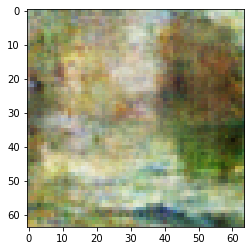

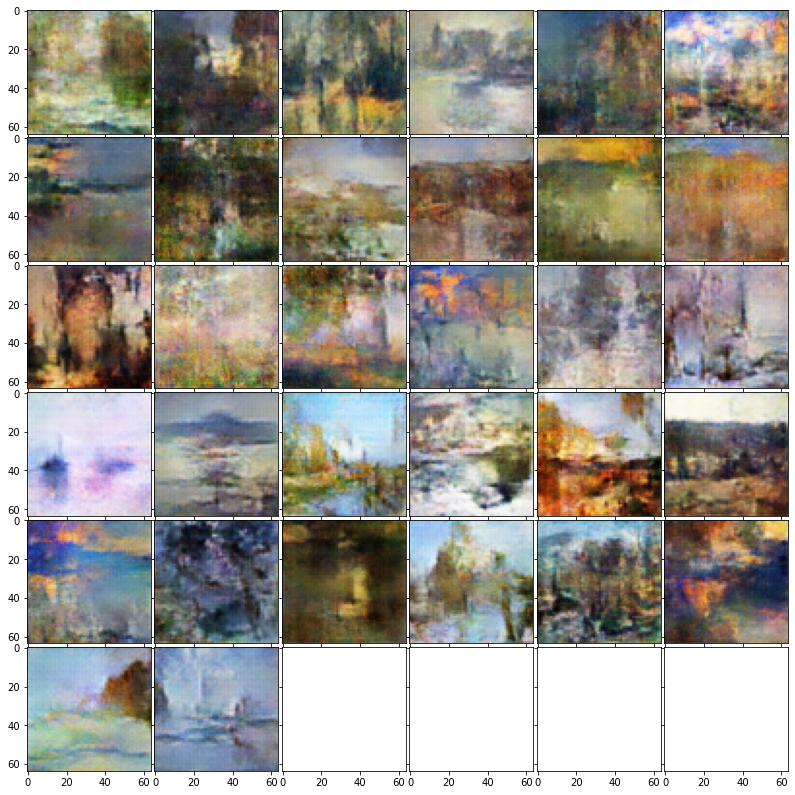

In [19]:
num_epochs = 200
real_label = 1.
fake_label = 0.
G_losses = []
D_losses = []
lowest_loss = float('inf')
best_fake = None

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        
        # zero out the gradient
        discriminator.zero_grad()
        real_data = data.to(device)
        batch_size = real_data.size(0)
        
        # real label tensor
        label = torch.full((batch_size,), real_label, dtype=real_data.dtype, device=device)
        # pass real label to D
        output = discriminator(real_data).view(-1)
        
        D_real_loss = criterion(output, label)
        # backpropagation 
        D_real_loss.backward()
        
        # generate random noise
        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)
        fake = generator(noise)
        
        # fake label tensor
        label.fill_(fake_label)
        # pass fake label to D
        output = discriminator(fake.detach()).view(-1)
        
        D_fake_loss = criterion(output, label)
        D_fake_loss.backward()
        
        D_loss = D_real_loss + D_fake_loss
        D_losses.append(D_loss.item())
        
        # update D's weights
        optimizerD.step()
        
        # zero out the gradient
        generator.zero_grad()
        
        label.fill_(real_label)  
        output = discriminator(fake).view(-1)
        
        G_loss = criterion(output, label)
        G_losses.append(G_loss.item())
        G_loss.backward()
        
        # update G's weights
        optimizerG.step()
        
        current_loss = G_losses[-1]
        if current_loss < lowest_loss:
            lowest_loss = current_loss
            # save the best fake images
            best_fake = fake.detach().cpu()

        print(f"[{epoch}/{num_epochs}][{i}/{len(dataloader)}] Loss_D: {D_loss.item()}, Loss_G: {G_loss.item()}")

show_image(best_fake[0], num_epochs, i, loss=lowest_loss, save=True)  
show_batch(best_fake, num_epochs, i, loss=lowest_loss, save=True) 

In [20]:
torch.save(generator.state_dict(), "generator.pt")
torch.save(discriminator.state_dict(), "discriminator.pt")

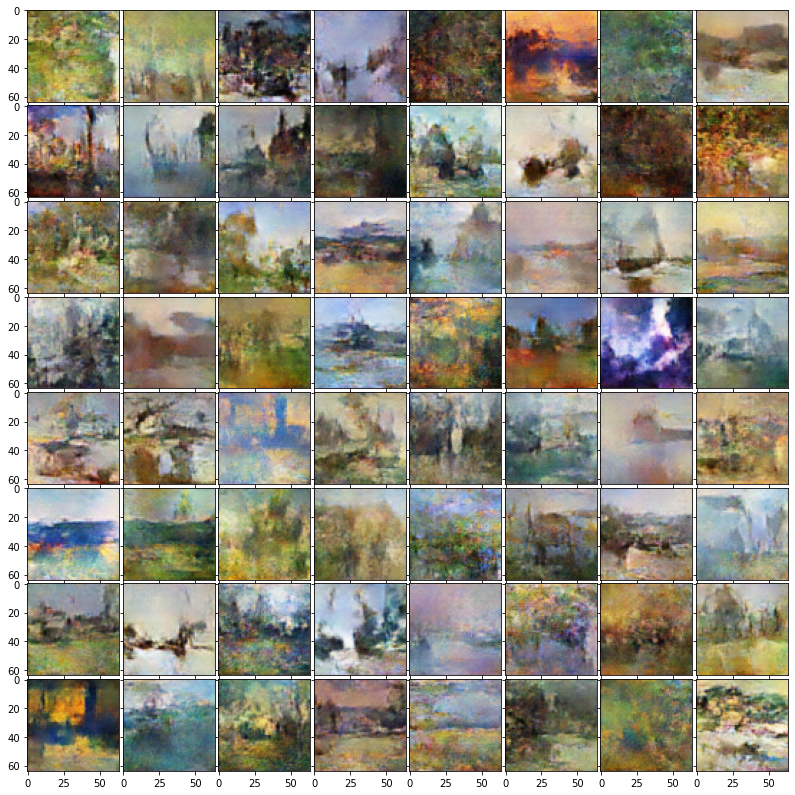

In [21]:
num_images = 64
noise = torch.randn(num_images, noise_dim, 1, 1, device=device)
fake_batch = generator(noise).detach().cpu()
show_batch(fake_batch)

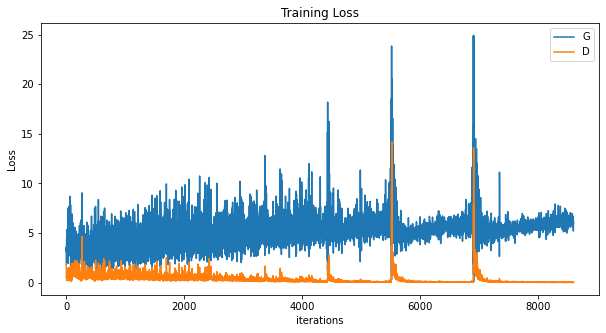

In [22]:
# Print Loss
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()